# Footprints: exploratory data analysis @ cell-type level

## Setup

In [5]:
import os
import sys
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
import anndata as ad
import scanpy as sc
import pyBigWig

In [6]:
# Ensure cwd is project root and that /code is in path

cwd = os.path.basename(os.getcwd())

if cwd == 'footprintQTL':
    
    PROJECT_DIR = '.'


elif cwd == 'code':
    
    PROJECT_DIR = '..'


elif cwd == 'fichtner':

    PROJECT_DIR = 'projects/footprintQTL'

else:

    PROJECT_DIR = 'manual'


os.chdir(PROJECT_DIR)
sys.path.append(os.getcwd() + '/code')

In [7]:
from helpers.python.utils import list_files_and_links, create_dir, middle_indexes
from helpers.python.anndata_utils import check_anndata

### User variables

In [8]:
cell_type = 'Neural-progenitors'
adata_path = f'results/datasets/hca_brain-organoids/atac-seq/footprints/js_divergence/approach_2024-09-12/footprints_{cell_type}_processed.h5ad'
min_cells_donor = 200 # Serves as sanity check.
                      # Ideally set to 0 since this filter should be applied during or before footprint computation

In [9]:

from glob_vars import GROUPED_BIGWIG_FILES_DIR, FOOTPRINTS_EDA

In [10]:
create_dir(FOOTPRINTS_EDA)

## Load data

In [11]:
adata = ad.read_h5ad(adata_path)

adata

AnnData object with n_obs × n_vars = 35 × 50789
    obs: 'cell_type', 'donor', 'donor_id', 'n_frags', 'n_insertions', 'n_cells', 'mean_BlacklistRatio', 'mean_nDiFrags', 'mean_nFrags', 'mean_nMonoFrags', 'mean_nMultiFrags', 'mean_NucleosomeRatio', 'mean_PassQC', 'mean_PromoterRatio', 'mean_ReadsInBlacklist', 'mean_ReadsInPromoter', 'mean_ReadsInTSS', 'mean_TSSEnrichment', 'mean_n_genes_by_counts', 'mean_total_counts', 'mean_total_counts_mt', 'mean_ReadsInPeaks', 'mean_FRIP', 'leiden'
    var: 'peak_name', 'chr', 'start', 'end', 'length', 'strand', 'score', 'GC', 'nearest_gene', 'peak_type', 'mean', 'std', 'var', 'min', 'max', '25%', '50%', '75%', 'highly_variable_std', 'std_rank'
    uns: 'leiden', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

### Checks

In [12]:
obs_criteria_kwargs = [
    {'col': 'n_cells', 'func': lambda x: (x > min_cells_donor).all()}
    ]

check_anndata(adata, min_obs=20, obs_criteria_kwargs=obs_criteria_kwargs)

## Descriptive stats

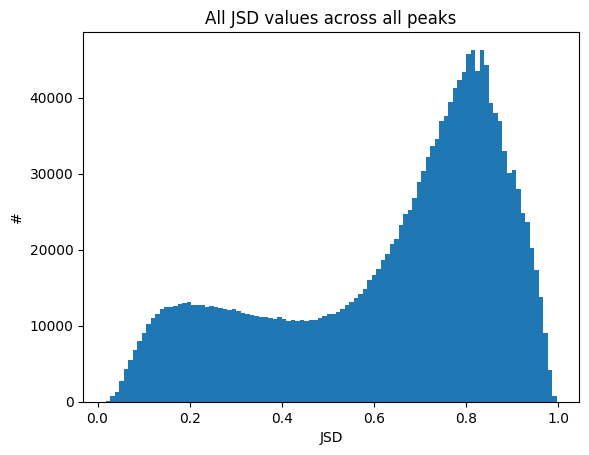

In [9]:
plt.hist(adata.X.toarray().flatten(), bins=100)
plt.title('All JSD values across all peaks')
plt.xlabel('JSD')
plt.ylabel('#')
plt.show()

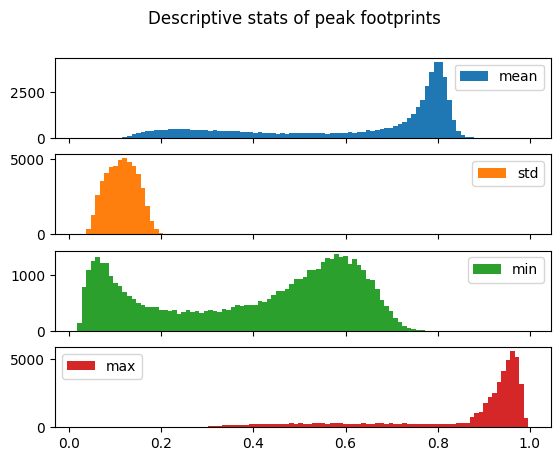

In [10]:
adata.var[['mean', 'std', 'min', 'max']].plot(kind='hist', bins=100, subplots=True, title='Descriptive stats of peak footprints', ylabel='');

### Mean-variance relationship

Text(0.5, 1.02, 'Mean-std')

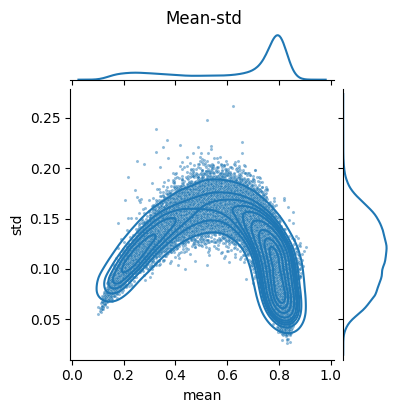

In [11]:
plot = sns.jointplot(adata.var, x='mean', y='std', kind='kde', height=4)
plot.plot_joint(sns.scatterplot, s=5, alpha=0.5)
plot.fig.suptitle('Mean-std', y=1.02)

Text(0.5, 1.02, 'Mean-var')

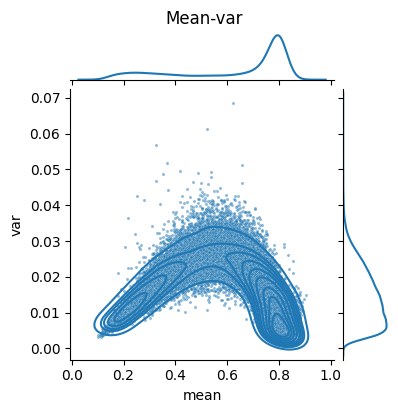

In [12]:
plot = sns.jointplot(adata.var, x='mean', y='var', kind='kde', height=4)
plot.plot_joint(sns.scatterplot, s=5, alpha=0.5)
plot.fig.suptitle('Mean-var', y=1.02)

### Log1p of scaled footprints

In [13]:
adata.layers['log1p'] = np.log((adata.X.toarray() + 0.0001) * 100)

mean_log1p = np.mean(adata.layers['log1p'], axis=0)
std_log1p = np.std(adata.layers['log1p'], axis=0)
var_log1p = std_log1p ** 2

df_log1p = pd.DataFrame([mean_log1p, std_log1p, var_log1p], index=['mean', 'std', 'var']).T

df_log1p

mean       std       var
0      3.376391  0.401113  0.160892
1      3.517067  0.445093  0.198108
2      2.838003  0.476026  0.226601
3      4.248544  0.210559  0.044335
4      3.393359  0.416328  0.173329
...         ...       ...       ...
50784  3.059707  0.461905  0.213357
50785  3.399308  0.427148  0.182456
50786  3.141594  0.505104  0.255130
50787  3.247813  0.430518  0.185346
50788  3.254515  0.498154  0.248158

[50789 rows x 3 columns]

Text(0.5, 14.722222222222216, 'Mean log1p scaled')

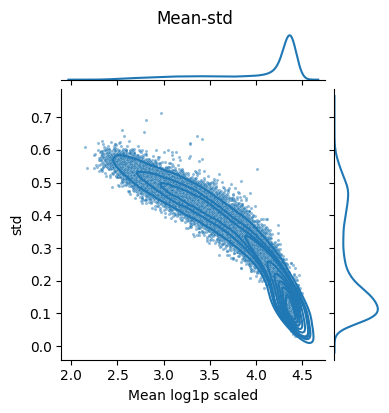

In [14]:
plot = sns.jointplot(df_log1p, x='mean', y='std', kind='kde', height=4)
plot.plot_joint(sns.scatterplot, s=5, alpha=0.5)
plot.fig.suptitle('Mean-std', y=1.02)
plot.ax_joint.set_xlabel('Mean log1p scaled')

Text(0.5, 14.722222222222216, 'Mean log1p scaled')

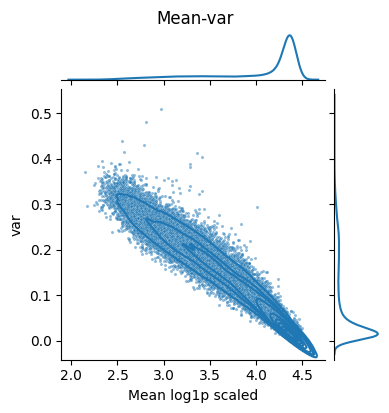

In [15]:
plot = sns.jointplot(df_log1p, x='mean', y='var', kind='kde', height=4)
plot.plot_joint(sns.scatterplot, s=5, alpha=0.5)
plot.fig.suptitle('Mean-var', y=1.02)
plot.ax_joint.set_xlabel('Mean log1p scaled')

## Variance analysis, clustering and embedding

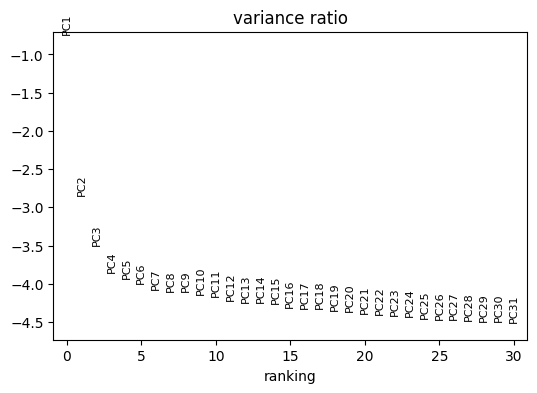

In [16]:
with plt.rc_context({"figure.figsize": (6, 4)}):

    sc.pl.pca_variance_ratio(adata, log=True)

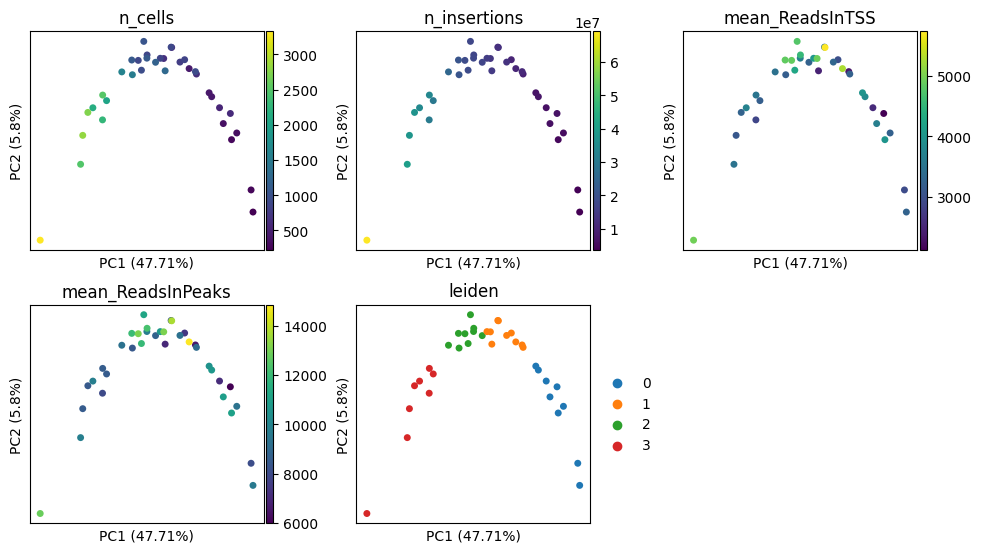

In [17]:
with plt.rc_context({"figure.figsize": (3, 3)}):
    
    sc.pl.pca(adata, size=100, 
                  annotate_var_explained=True, 
                  color=('n_cells', 'n_insertions', 'mean_ReadsInTSS', 'mean_ReadsInPeaks', 'leiden'), 
                  ncols=3)

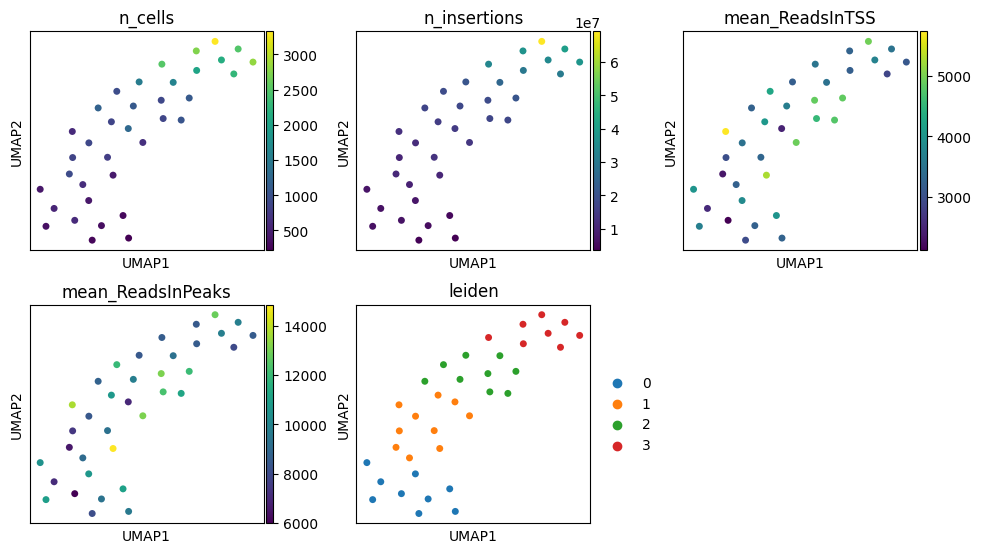

In [18]:
with plt.rc_context({"figure.figsize": (3, 3)}):
    
    sc.pl.umap(
        adata,
        color=['n_cells', 'n_insertions', 'mean_ReadsInTSS', 'mean_ReadsInPeaks', 'leiden'],
        size=100,
        ncols=3)

## HVP analysis

### Get necessary data

In [ ]:
# Top, mid, low variable peaks

n_top_hvps = 2
n_mid_vps = 2
n_low_vps = 2

c_d, c_u = middle_indexes(length=len(adata.var), radial_range=n_mid_vps)

top_hvps = adata.var['std_rank'].sort_values()[0:n_top_hvps].index.to_list()
mid_vps = adata.var['std_rank'].sort_values()[c_d:c_u].index.to_list()
low_vps = adata.var['std_rank'].sort_values()[-n_low_vps:].index.to_list()
peaks = top_hvps + mid_vps + low_vps
peaks

['chr2:11420:11920:501:*:2',
 'chr2:193502476:193502976:501:*:48623',
 'chr3:140359167:140359667:501:*:35843',
 'chr2:177031485:177031985:501:*:44987',
 'chr2:108385667:108386167:501:*:28106',
 'chr1:101976083:101976583:501:*:32792']

In [ ]:
# Top, mid, low JSD donors for selected peaks
n_top_donors = 2
n_mid_donors = 2
n_low_donors = 2

tml_std_jsd_peaks = {peak: {} for peak in peaks} # peak: {donor: jsd} for n_top,mid,low_jsd_donors
tml_std_jsd_peaks_donor_order = {} # peak: [donors]

for peak in peaks:

    c_d, c_u = middle_indexes(length=adata.n_obs, radial_range=n_mid_donors)

    top_jsd_peak_series_sorted = adata[:, peak].to_df()[peak].sort_values(ascending=False)[0:n_top_donors]
    mid_jsd_peak_series_sorted = adata[:, peak].to_df()[peak].sort_values(ascending=False)[c_d:c_u]
    low_jsd_peak_series_sorted = adata[:, peak].to_df()[peak].sort_values(ascending=False)[-n_low_donors:]

    # Get donor->jsd
    top_jsd_donors_jsd = top_jsd_peak_series_sorted.to_dict()
    mid_jsd_donors_jsd = mid_jsd_peak_series_sorted.to_dict()
    low_jsd_donors_jsd = low_jsd_peak_series_sorted.to_dict()

    tml_std_jsd_peaks[peak] = {**top_jsd_donors_jsd, **mid_jsd_donors_jsd, **low_jsd_donors_jsd}

    # Get donor order
    top_jsd_donors = top_jsd_peak_series_sorted.index.to_list()
    mid_jsd_donors = mid_jsd_peak_series_sorted.index.to_list()
    low_jsd_donors = low_jsd_peak_series_sorted.index.to_list()

    tml_std_jsd_peaks_donor_order[peak] = [*top_jsd_donors, *mid_jsd_donors, *low_jsd_donors]


tml_std_jsd_peaks[list(tml_std_jsd_peaks.keys())[0]]

{'kajh': 0.9875664395160835,
 'eika': 0.9855892668474151,
 'qayj': 0.6533539799203952,
 'iisa': 0.6179725927450905,
 'vuna': 0.14036951209079632,
 'lexy': 0.12459023914558807}

In [63]:
# Peak profiles

peak_profiles = {peak: {} for peak in peaks} # peak: {donor: [profile.np]}

bw_files = list_files_and_links(os.path.join(GROUPED_BIGWIG_FILES_DIR, cell_type))

for bw_file in bw_files:

    donor = bw_file.rstrip('.bw').split('_')[0]
    bw_path_full = os.path.join(GROUPED_BIGWIG_FILES_DIR, cell_type, bw_file)


    # Avoid empty bigwigs
    if not os.stat(bw_path_full).st_size == 0:


        bw = pyBigWig.open(bw_path_full)


        for peak in peaks:
    
            chr, start, end = adata.var.loc[peak, ['chr', 'start', 'end']]

            profile = bw.values(chr, int(start) - 1, int(end))
            profile = np.nan_to_num(profile, nan=0)

            peak_profiles[peak][donor] = profile


        bw.close()

In [64]:
# Peak profiles average across donors

peak_profiles_average = {} # peak: average

for peak in peaks:

    profiles_matrix = np.stack(list(peak_profiles[peak].values()))
    peak_profiles_average[peak] = np.average(profiles_matrix, axis=0)


# Peak profiles sum across donors

peak_profiles_sum = {} # peak: sum

for peak in peaks:

    profiles_matrix = np.stack(list(peak_profiles[peak].values()))
    peak_profiles_sum[peak] = np.sum(profiles_matrix, axis=0)

### Plot: HVP profiles and average profile

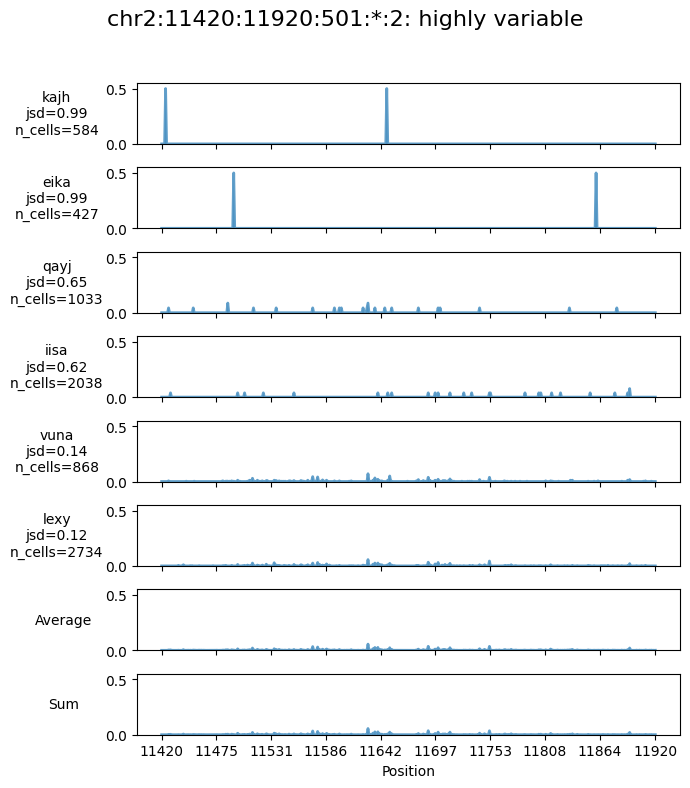

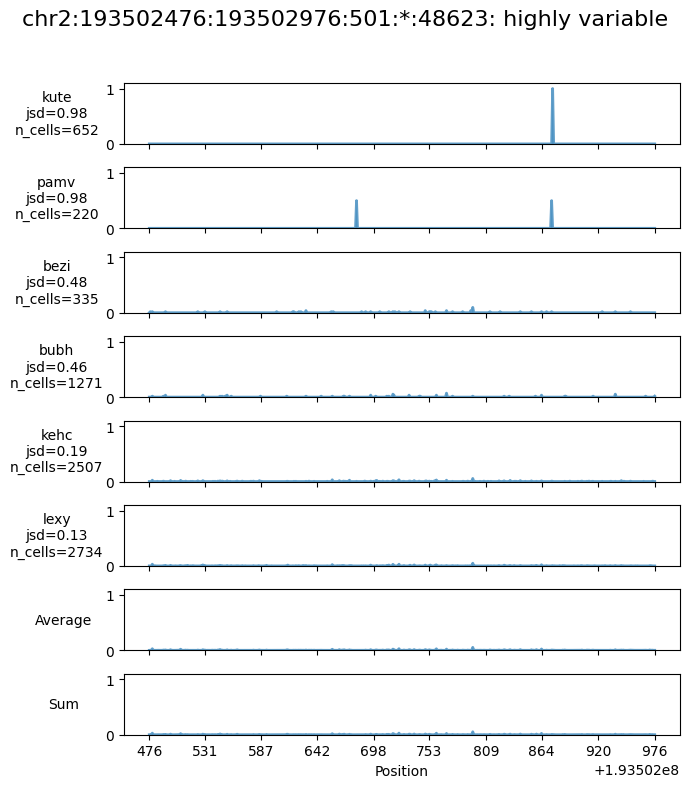

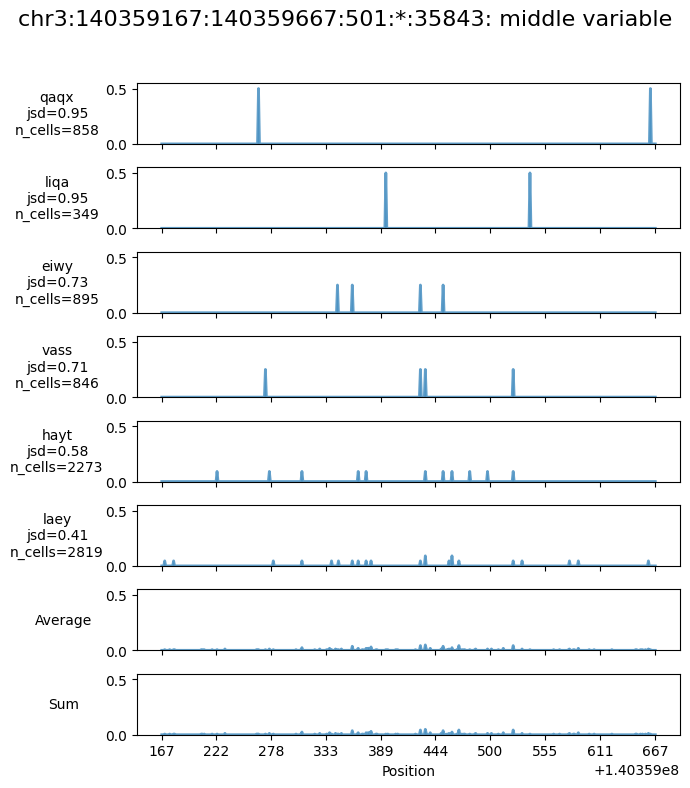

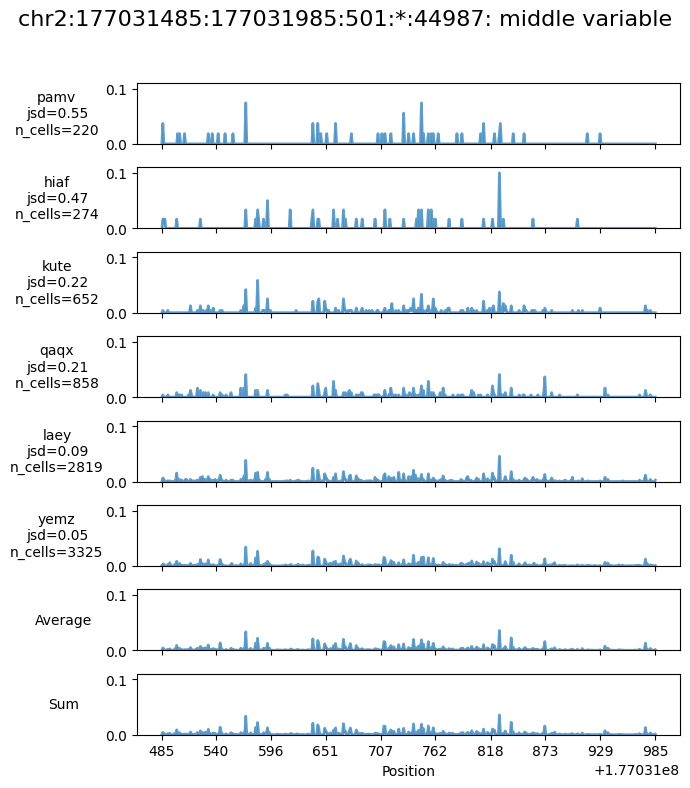

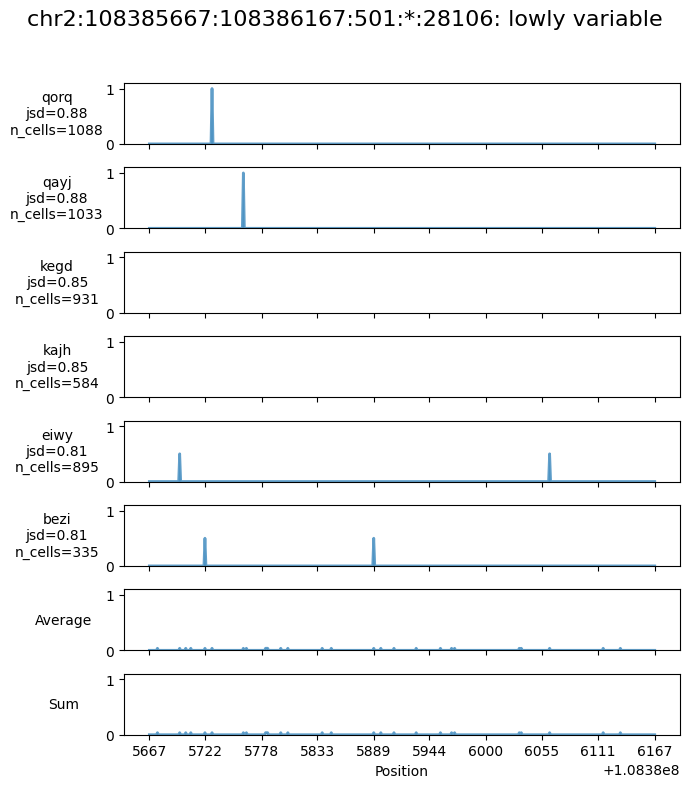

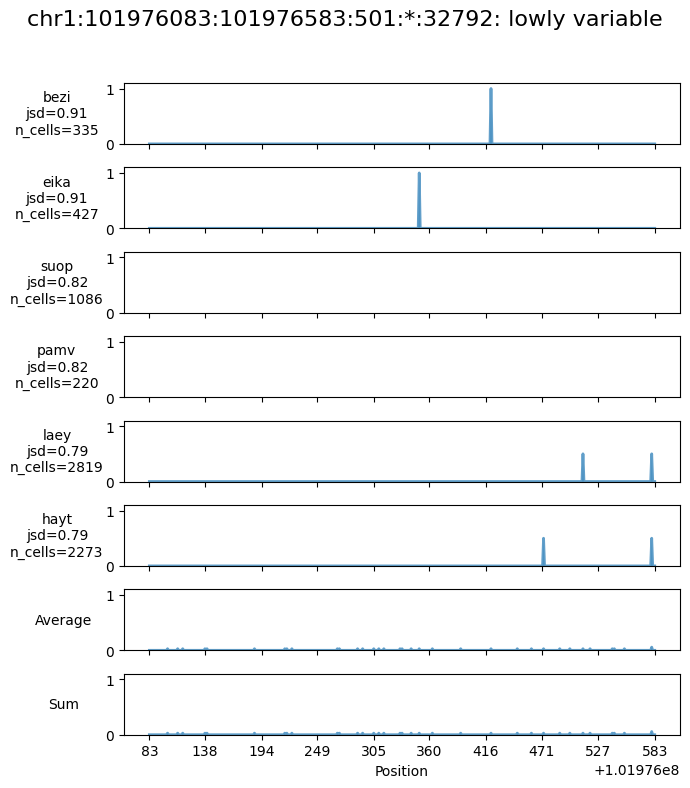

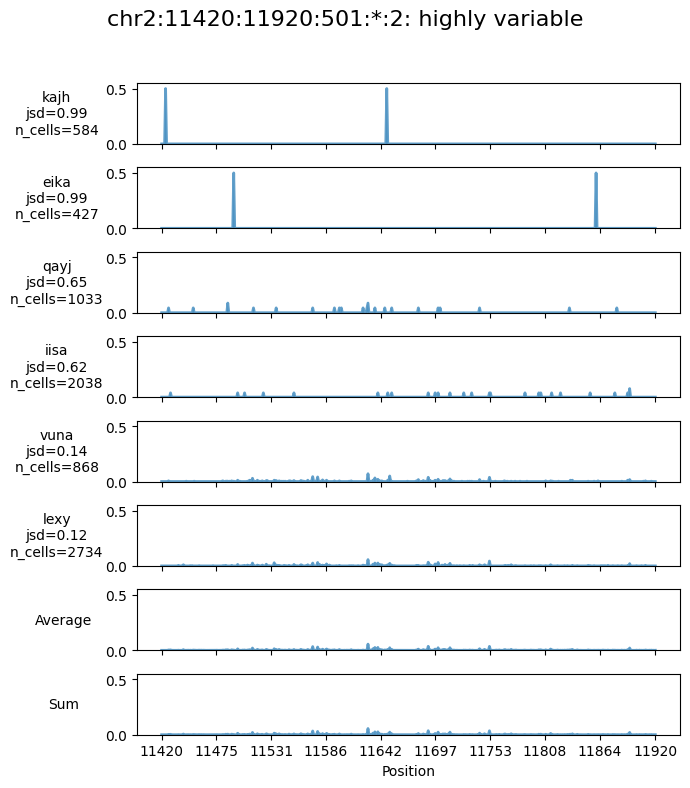

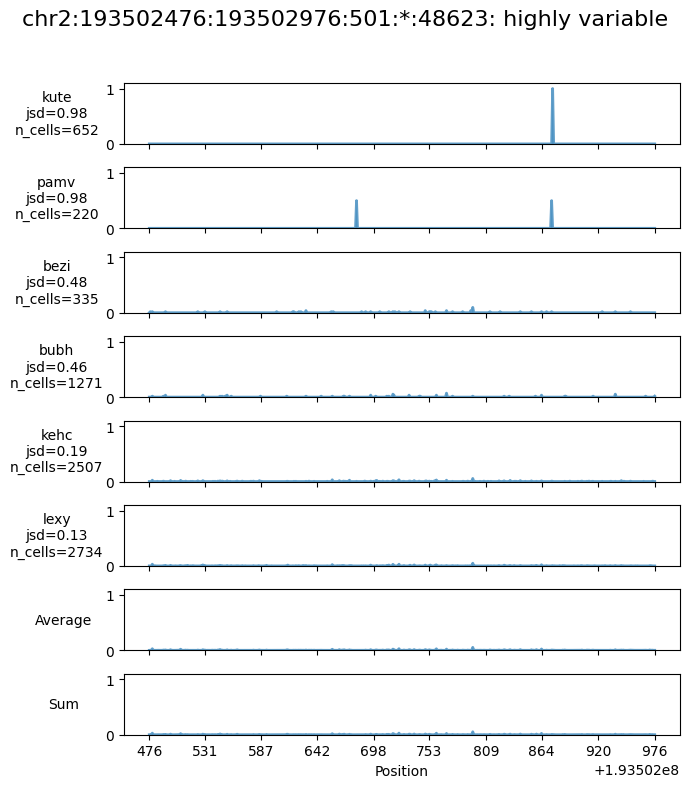

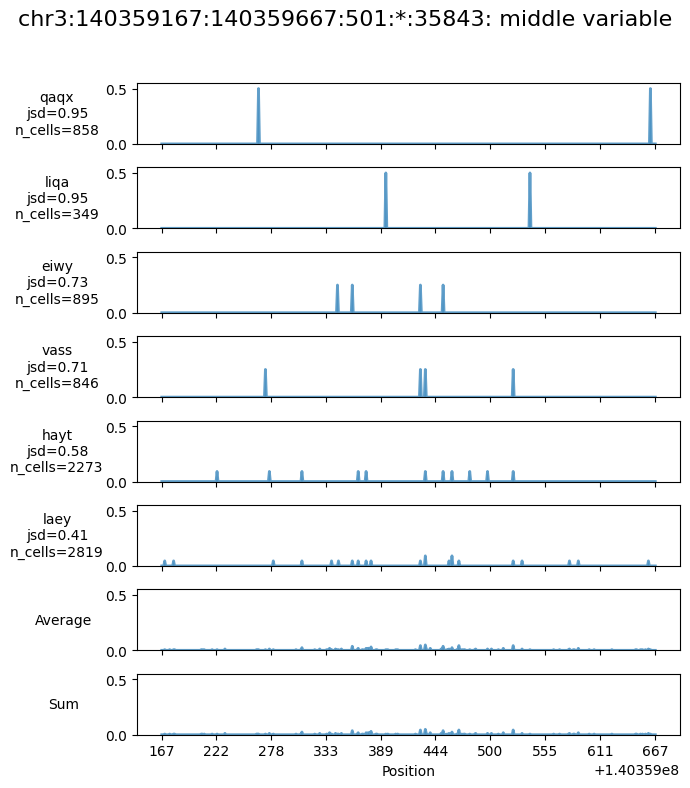

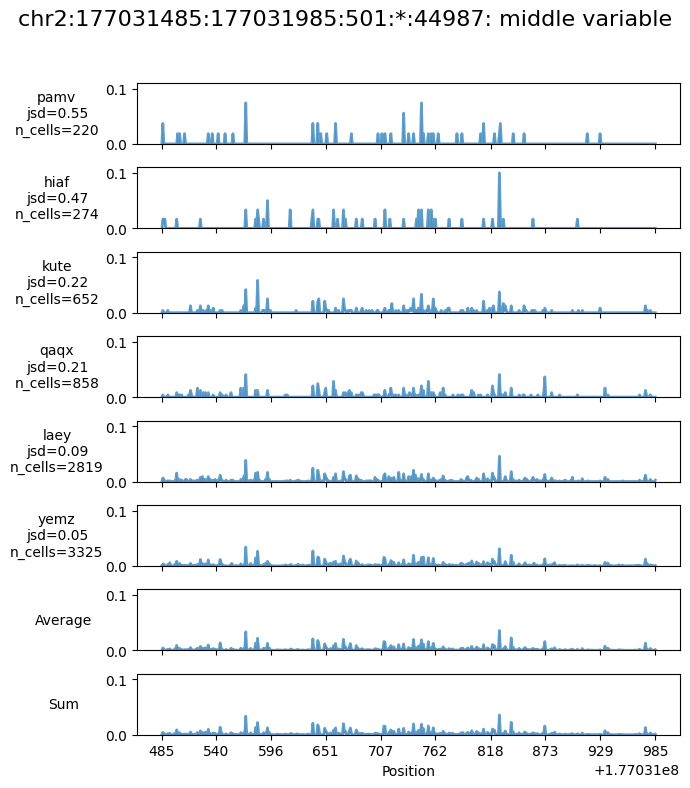

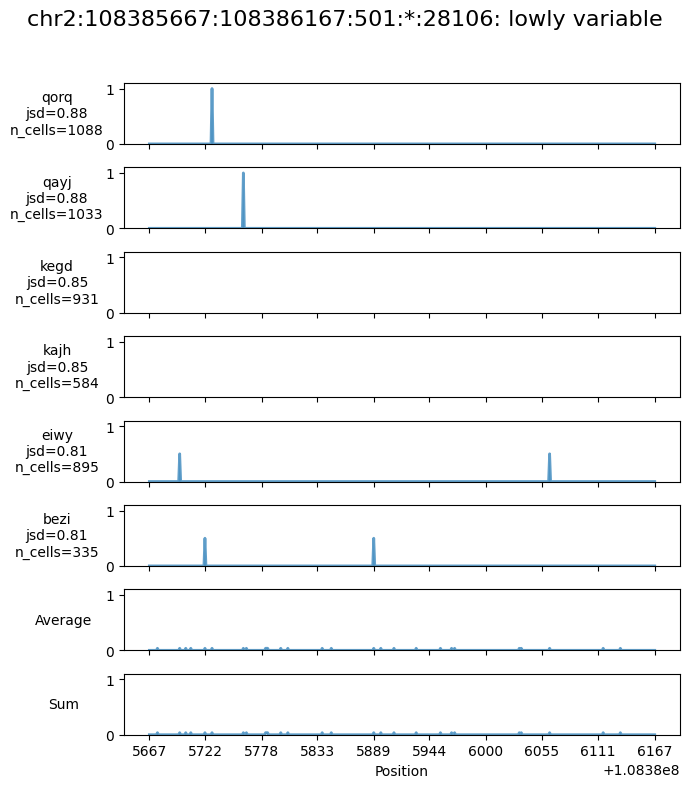

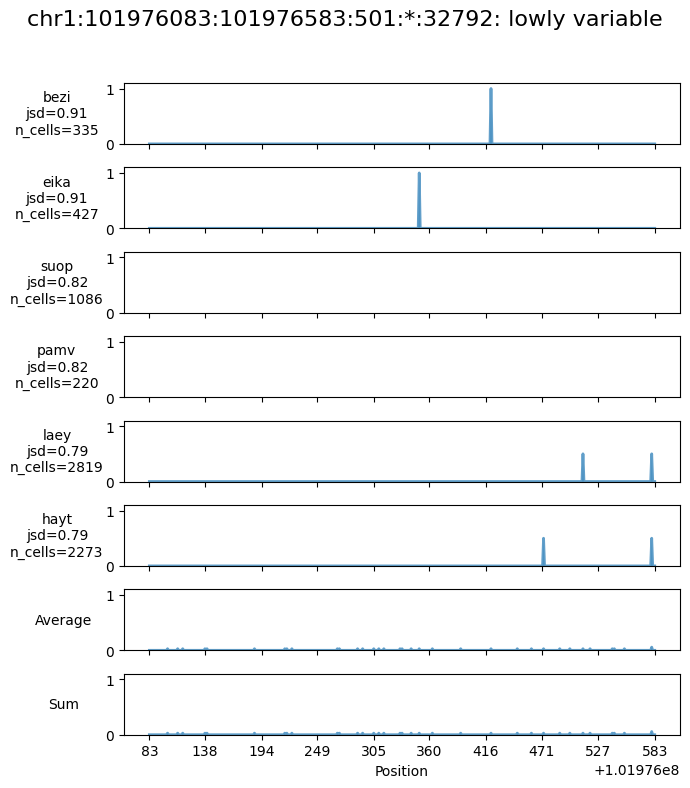

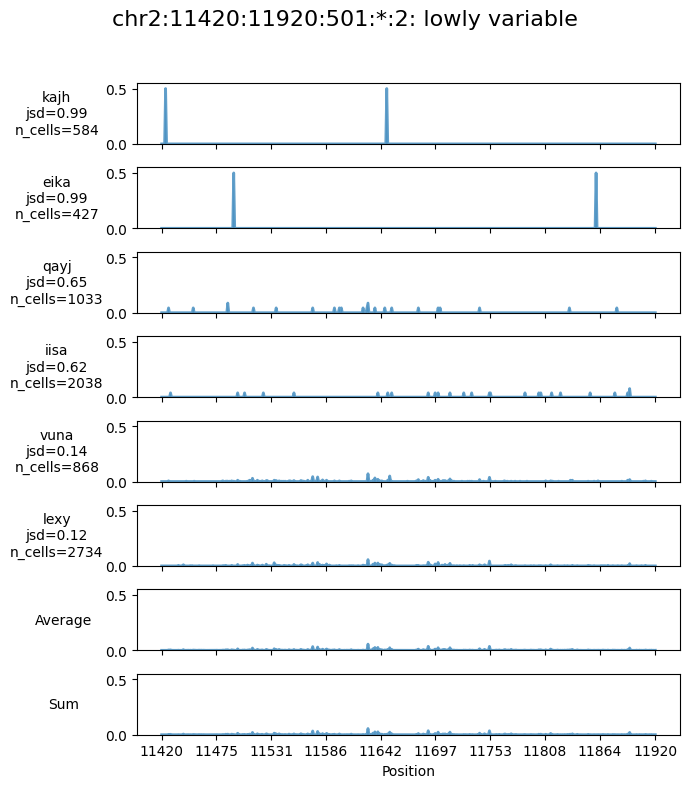

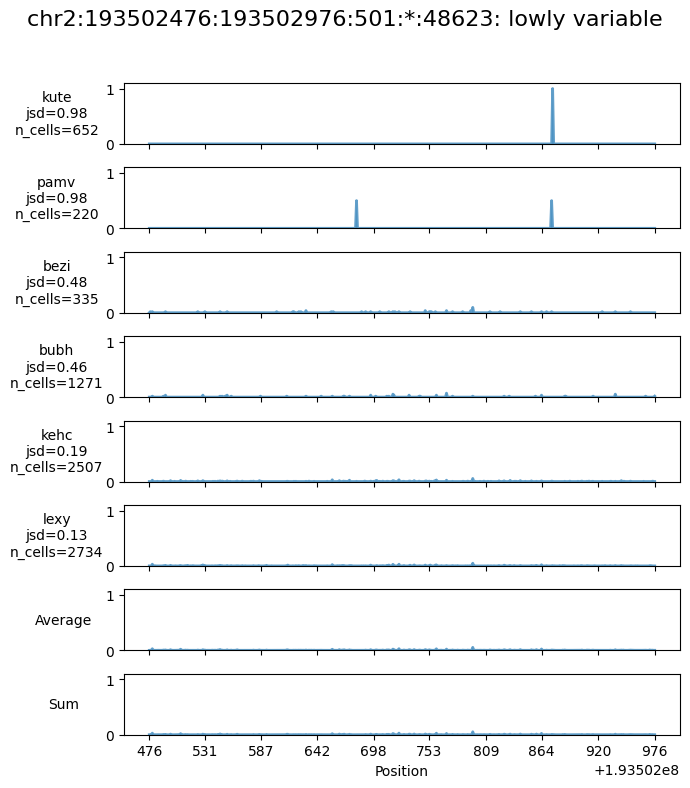

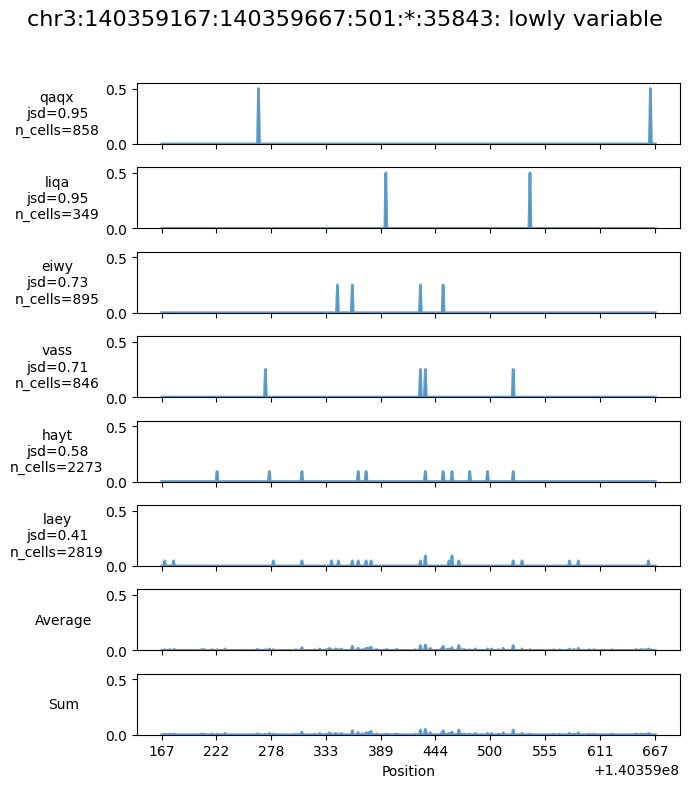

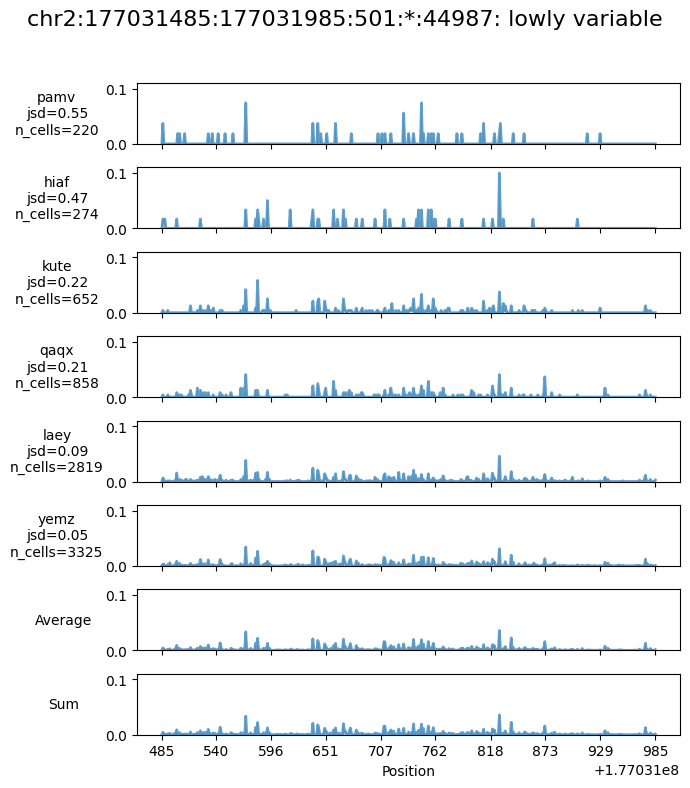

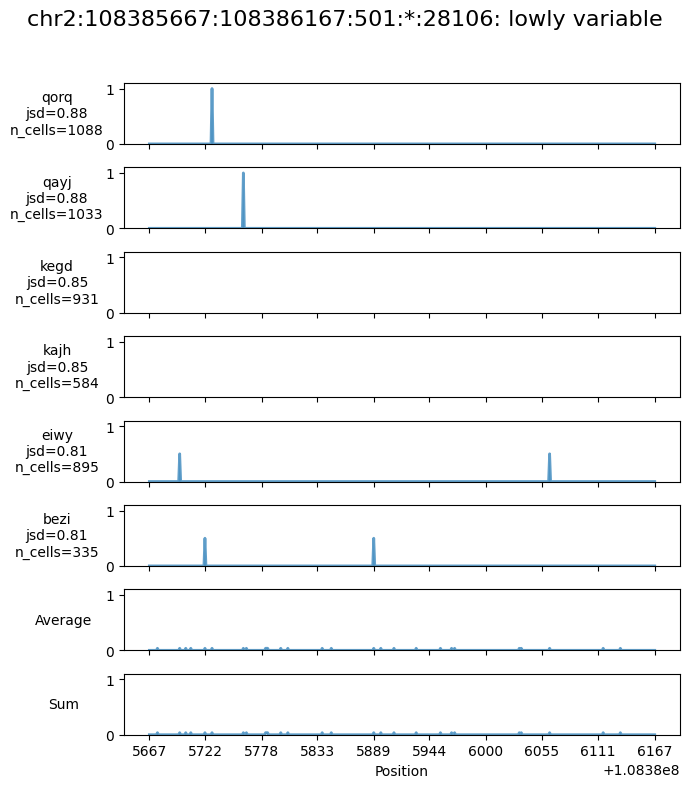

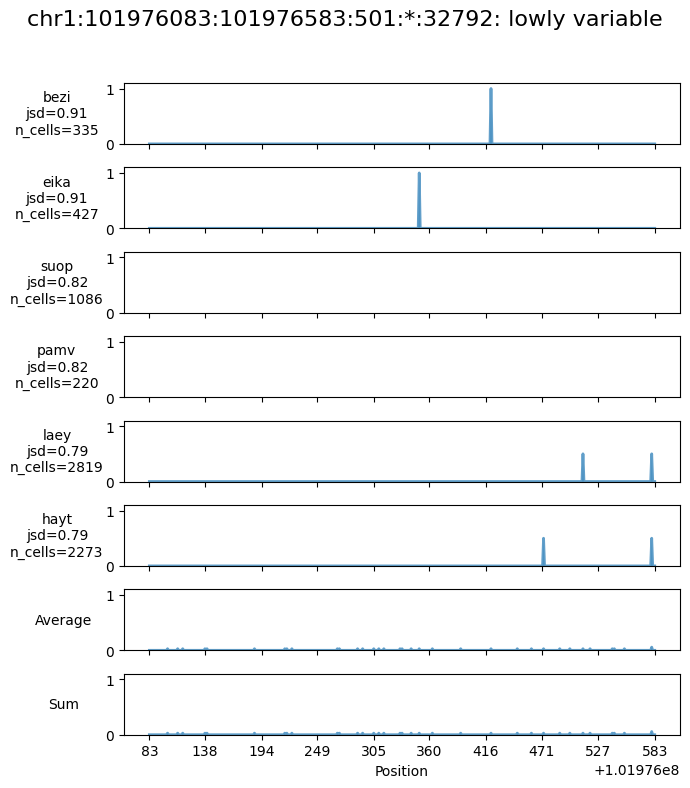

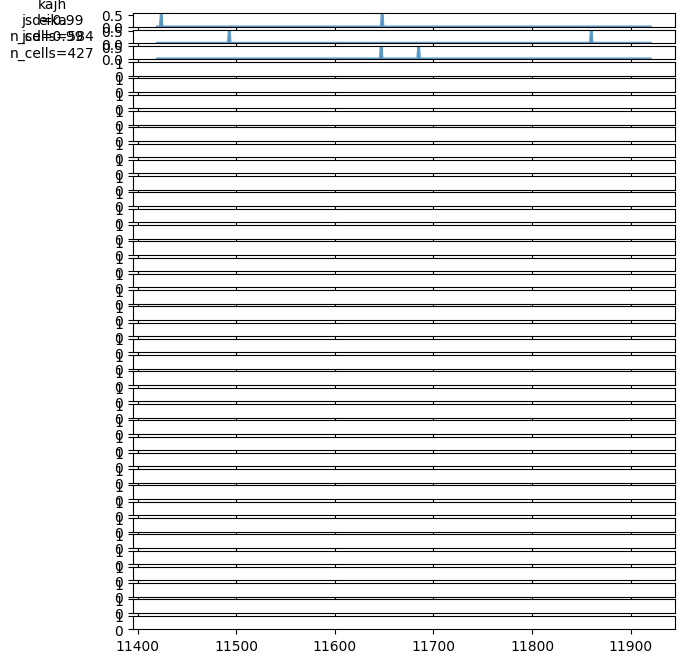

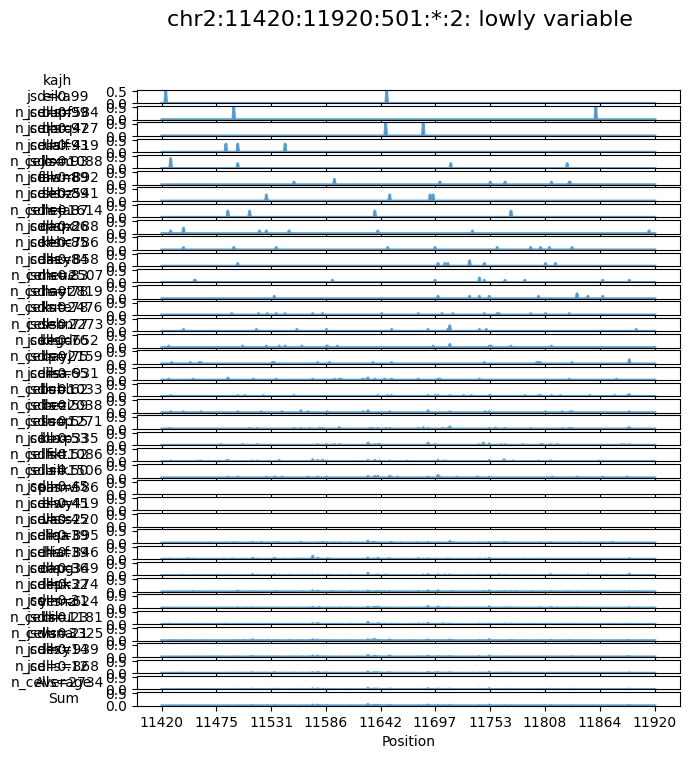

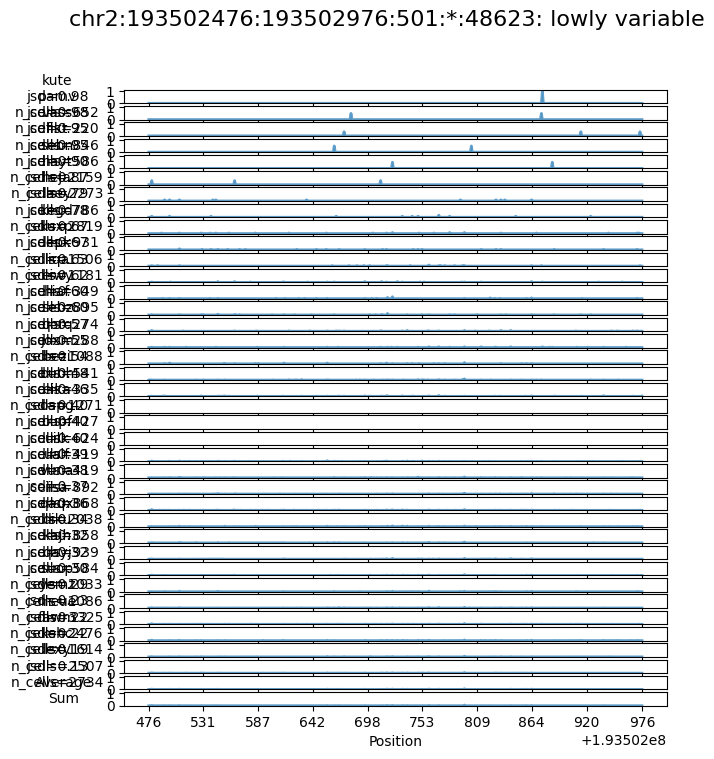

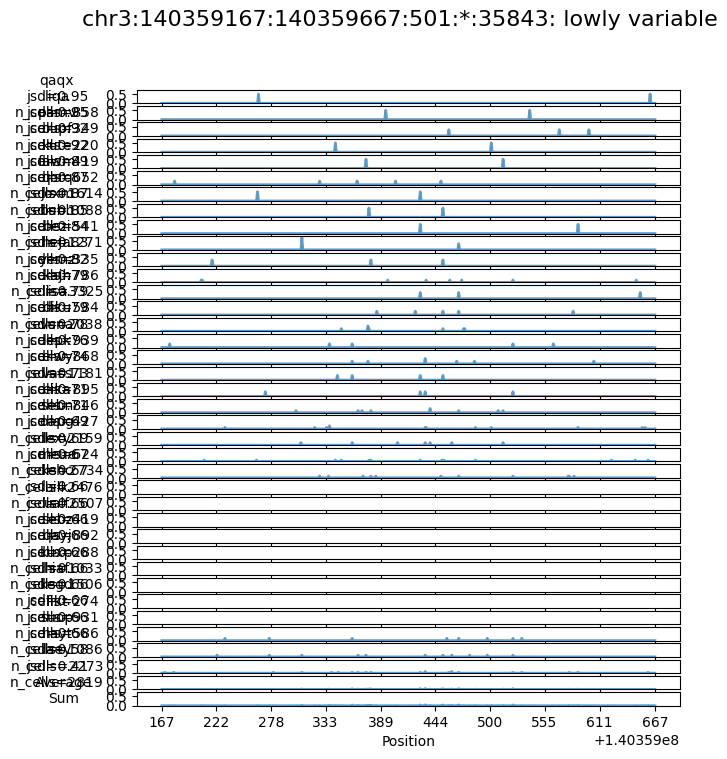

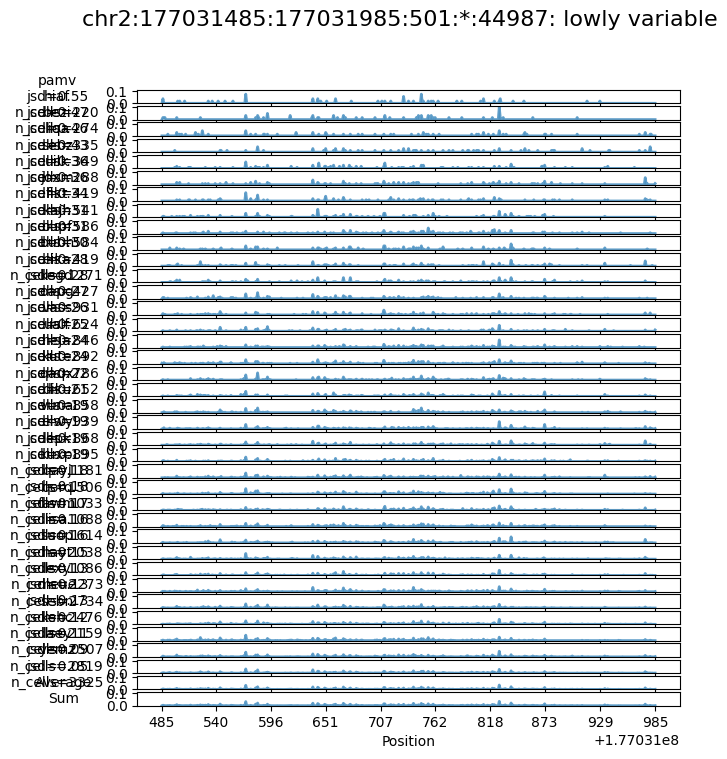

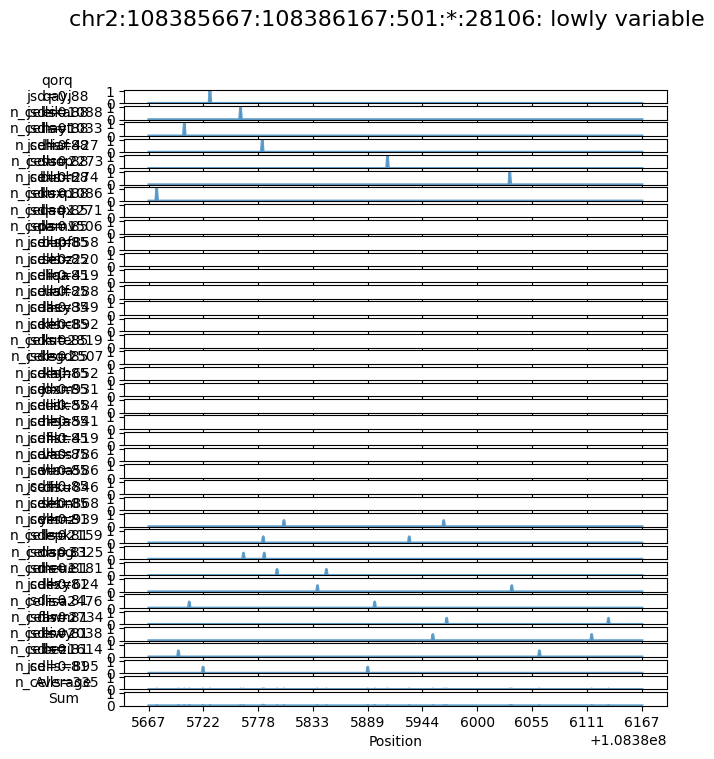

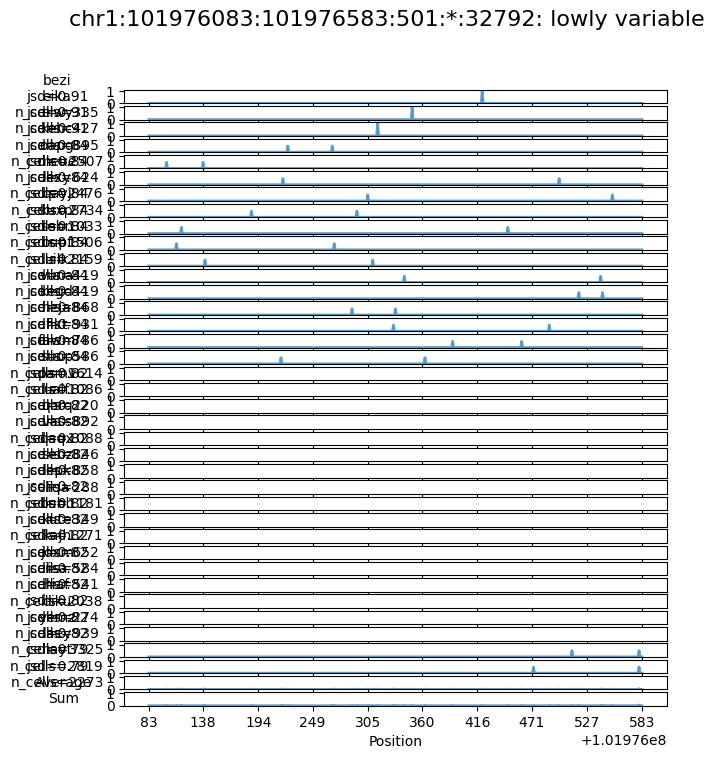

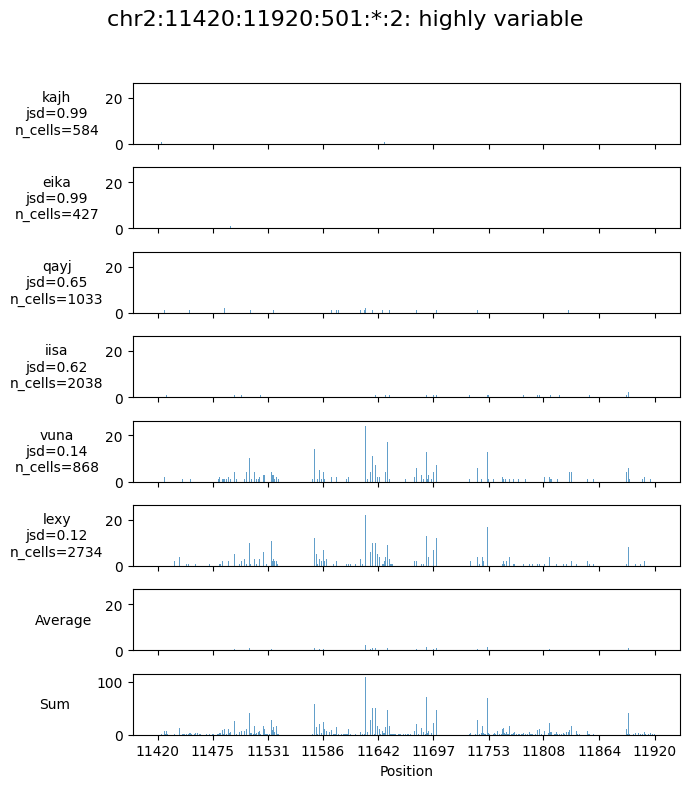

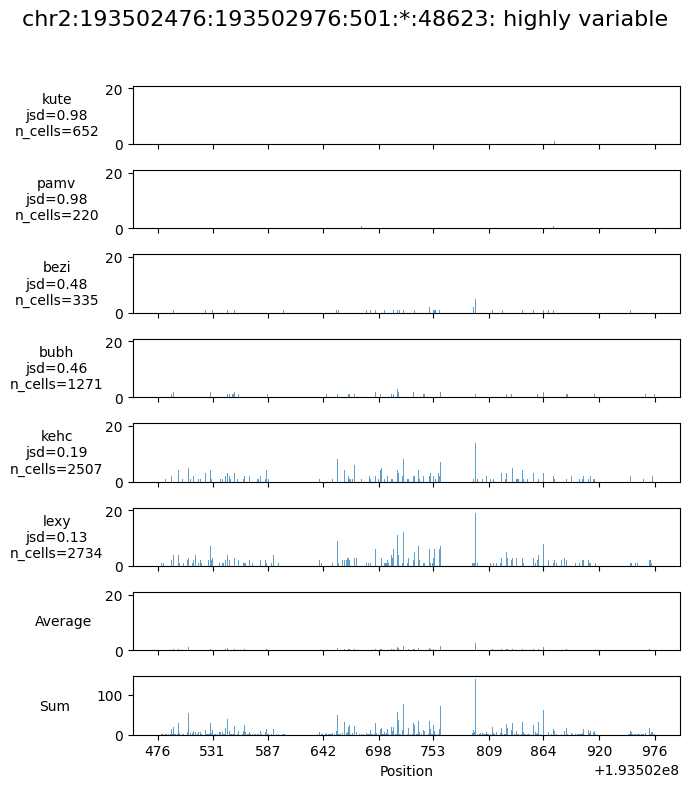

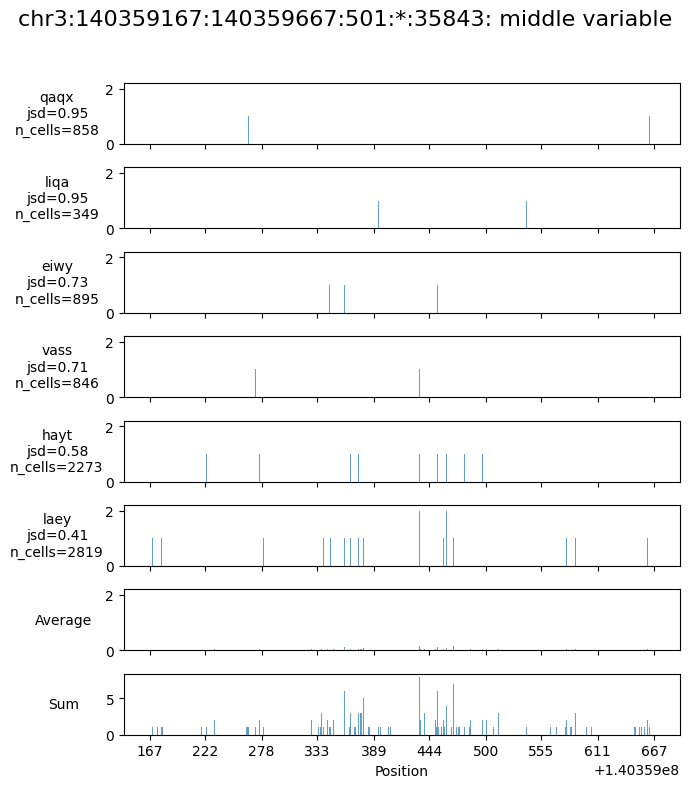

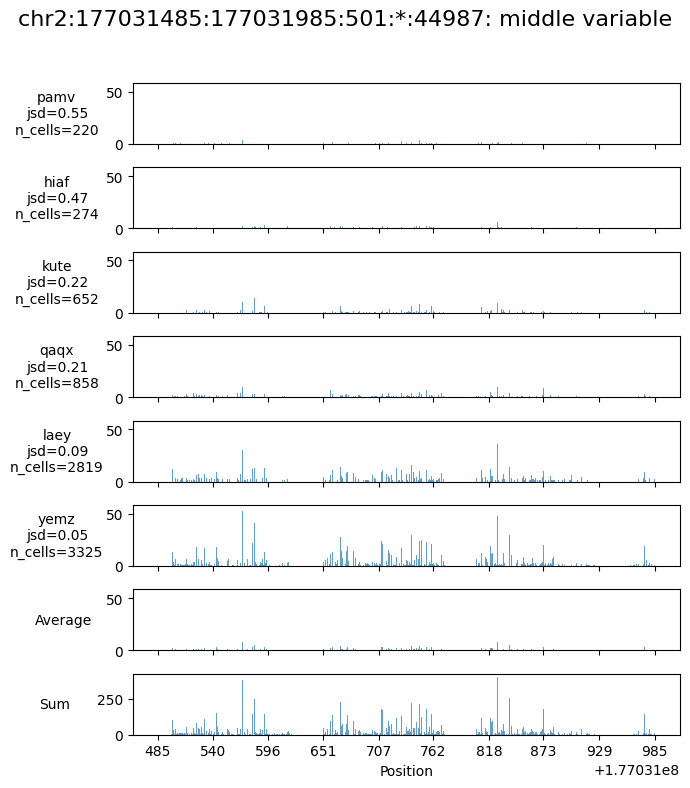

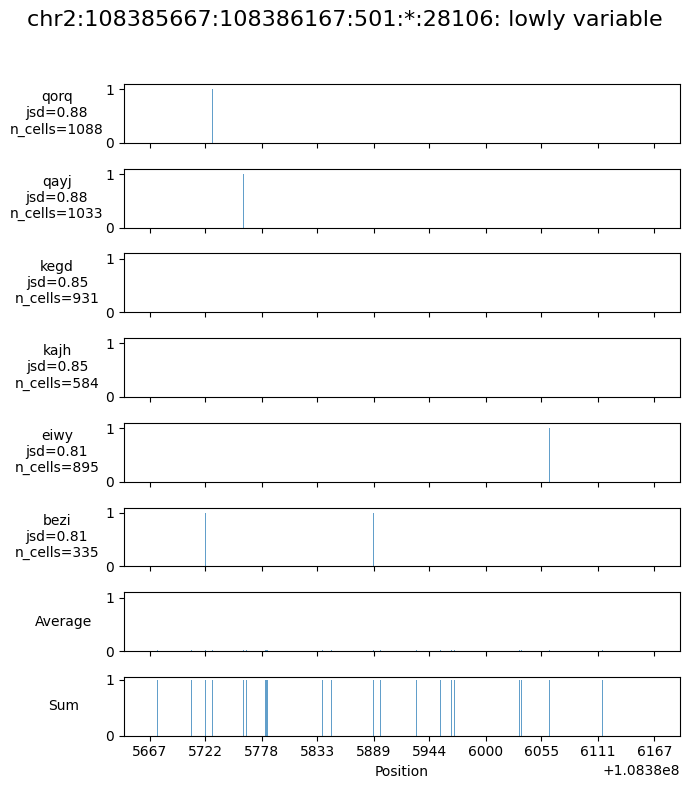

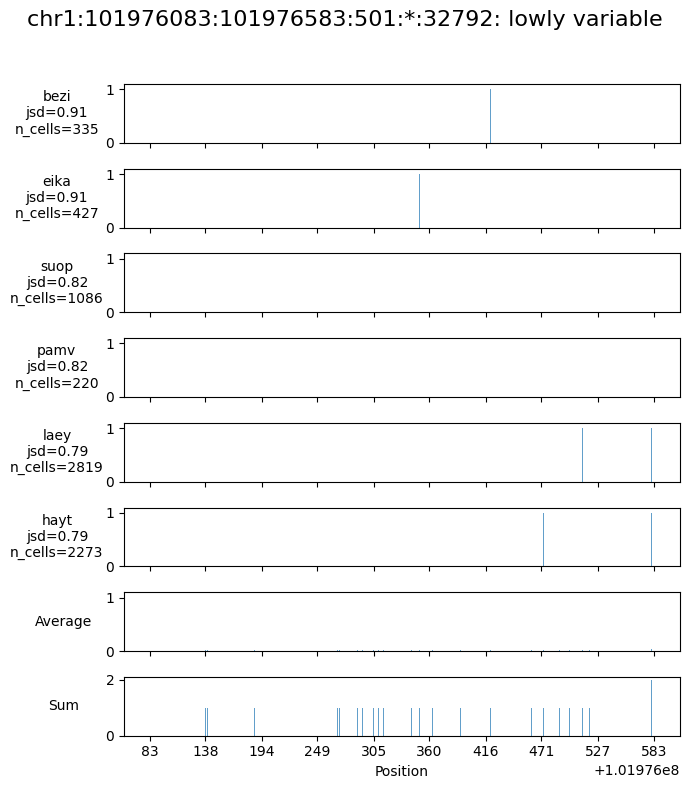

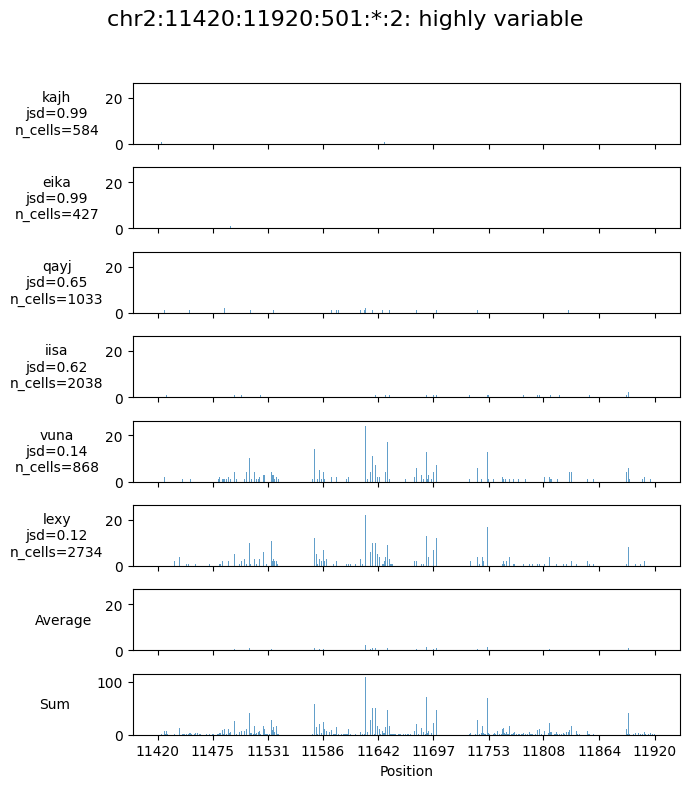

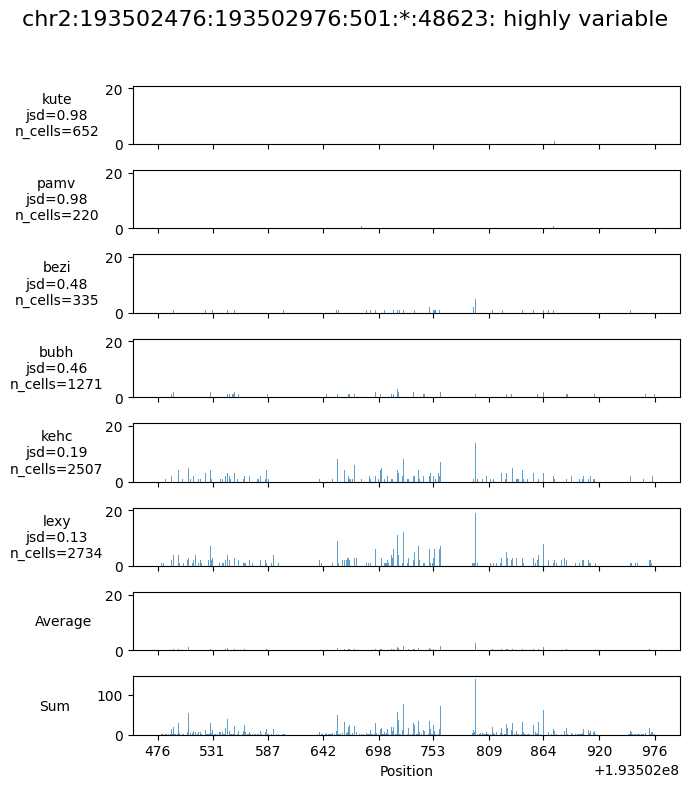

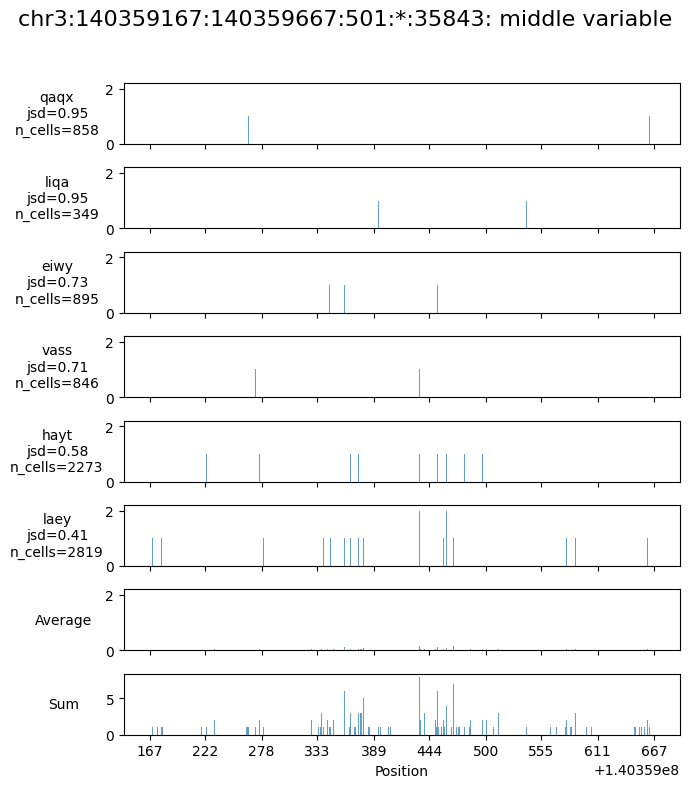

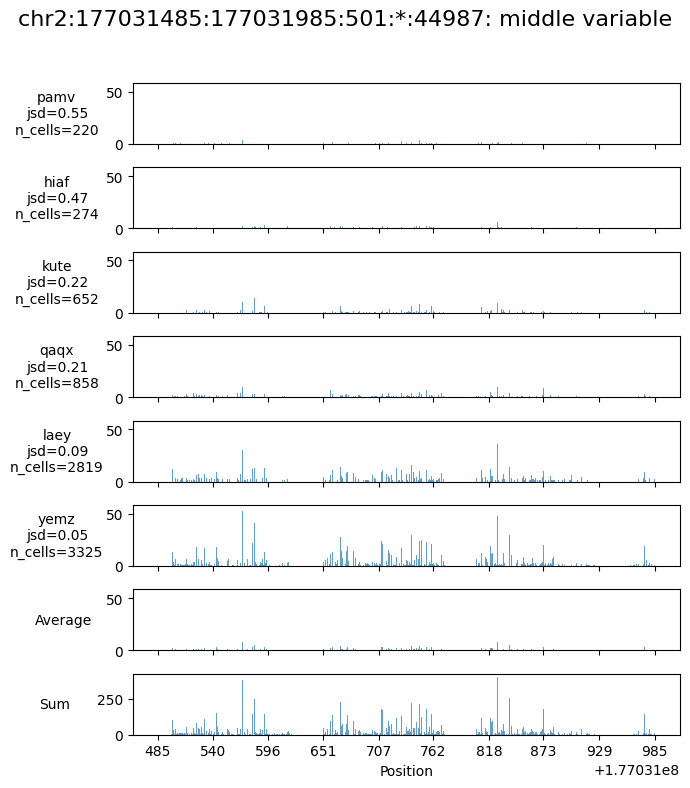

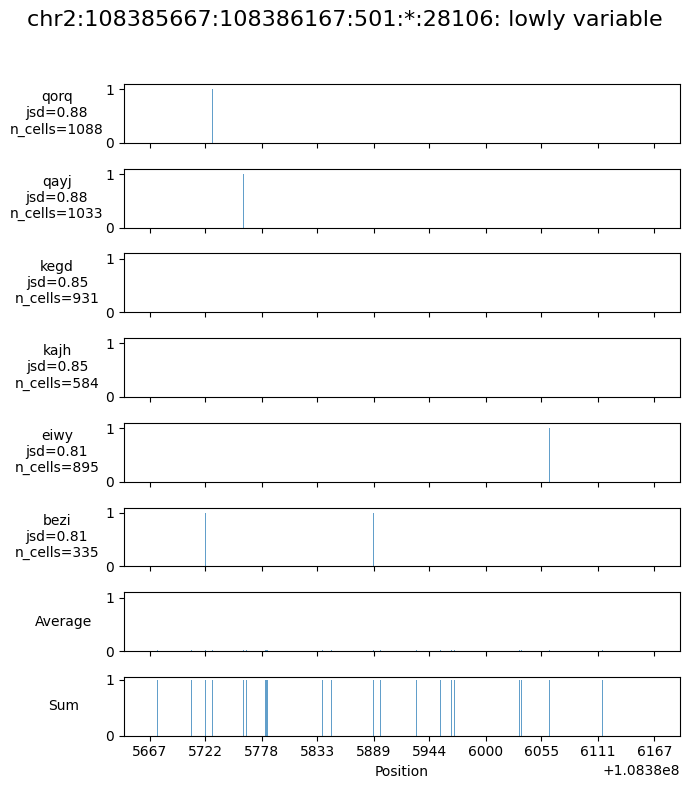

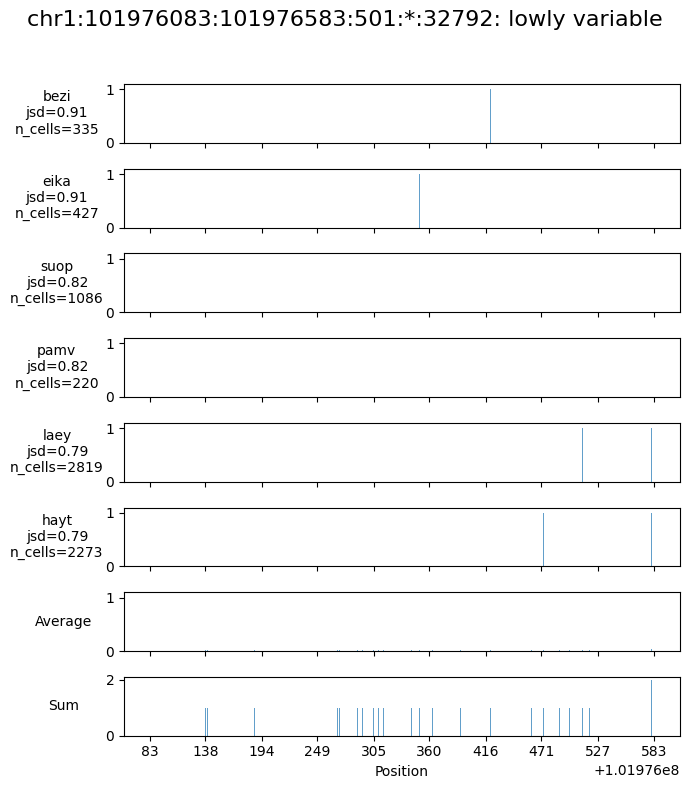

In [67]:
# Histogram/Barplot

for count, peak in enumerate(peaks):

    # Top, middle or low variance/std?
    if count < n_top_hvps:
        
        peak_type = 'highly'

    elif n_top_hvps <= count < n_top_hvps+n_mid_vps:

        peak_type = 'middle'

    elif count >= n_top_hvps+n_mid_vps:

        peak_type = 'lowly'

    # Make objects
    arrays = [peak_profiles[peak][donor] for donor in tml_std_jsd_peaks[peak].keys()]
    arrays.append(peak_profiles_average[peak])
    arrays.append(peak_profiles_sum[peak])

    array_labels = [donor for donor in tml_std_jsd_peaks[peak].keys()]
    array_labels.append('Average')
    array_labels.append('Sum')

    chr, start, end = adata.var.loc[peak, ['chr', 'start', 'end']].to_list()
    positions = np.arange(int(start), int(end) + 1)

    # Check
    assert len(set([len(a) for a in arrays])) == 1
    assert len(positions) == len(arrays[0])

    common_ylim = max(max(a) for a in arrays[0:-1]) * 1.1
    # ylim_sum = max(arrays[-1]) * 3.0

    fig, axes = plt.subplots(len(arrays), 1, figsize=(7, 8), sharex=True)

    for i, (array, ax) in enumerate(zip(arrays, axes)):

        donor = array_labels[i]
        
        ax.bar(positions, array, alpha=0.7)

        if array_labels[i] == 'Average':

            ax.set_ylabel(array_labels[i], rotation=0, labelpad=30, va='center')

            ax.set_ylim(0, common_ylim)


        elif array_labels[i] == 'Sum':

            ax.set_ylabel(array_labels[i], rotation=0, labelpad=30, va='center')

            # ax.set_ylim(0, ylim_sum)


        else:

            ax.set_ylabel('{}\njsd={:.2f}\nn_cells={}'.format(
                array_labels[i],
                tml_std_jsd_peaks[peak][donor],
                int(adata.obs.loc[donor, 'n_cells'])
                ), rotation=0, labelpad=35, va='center')

            ax.set_ylim(0, common_ylim)

        # ax.grid(axis='y', linestyle='--', alpha=0.7)

    ax.set_xticks(np.linspace(positions[0], positions[-1], num=10, dtype=int))  # Use 10 evenly spaced ticks

    plt.xlabel('Position')
    fig.suptitle(f'{peak}: {peak_type} variable', fontsize=16) # ATAC-seq footprint, top/mid/low JSD donors\n\n
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit the title
    plt.show()

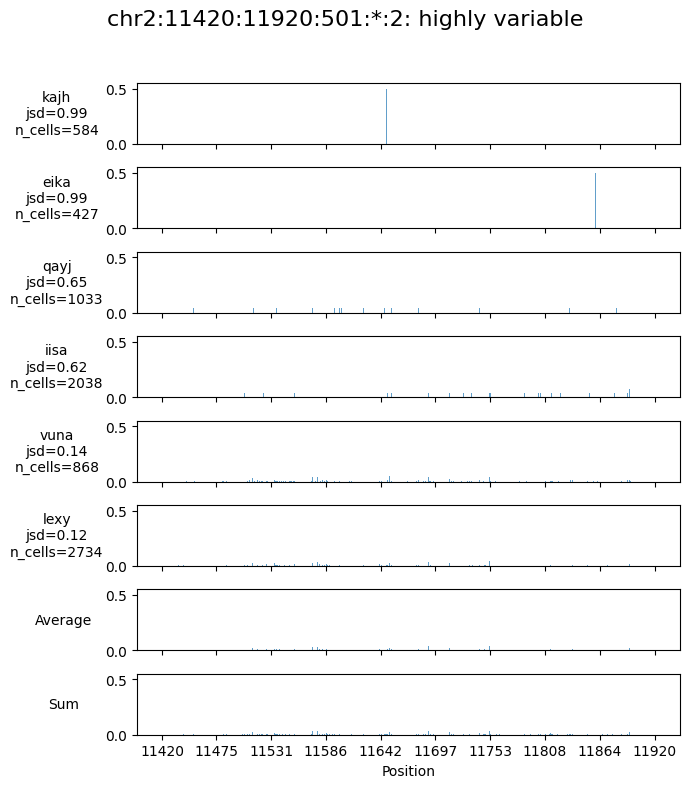

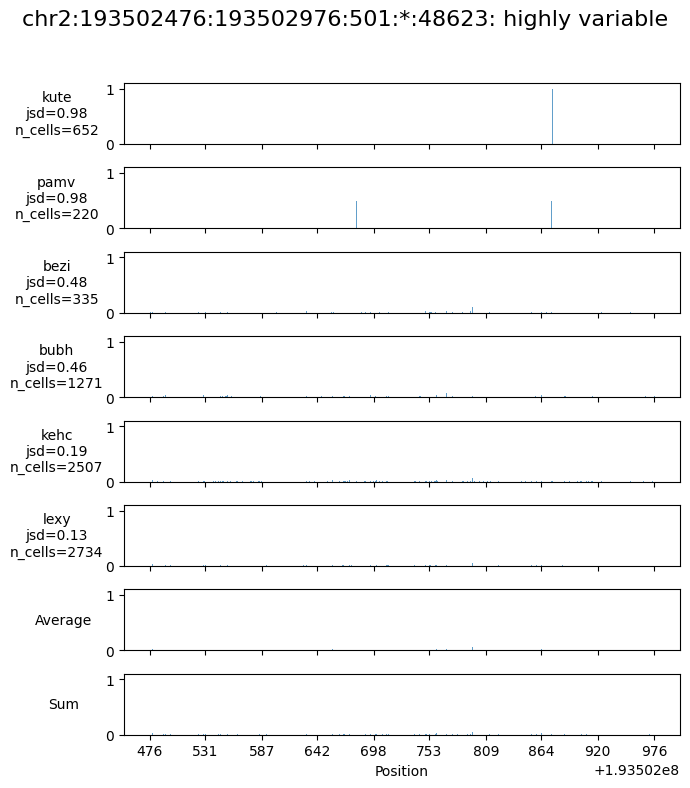

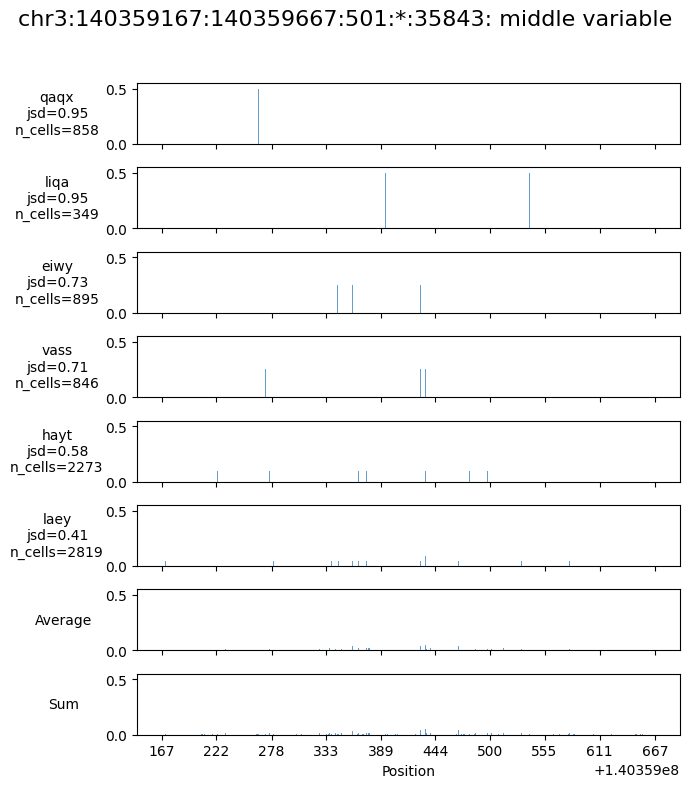

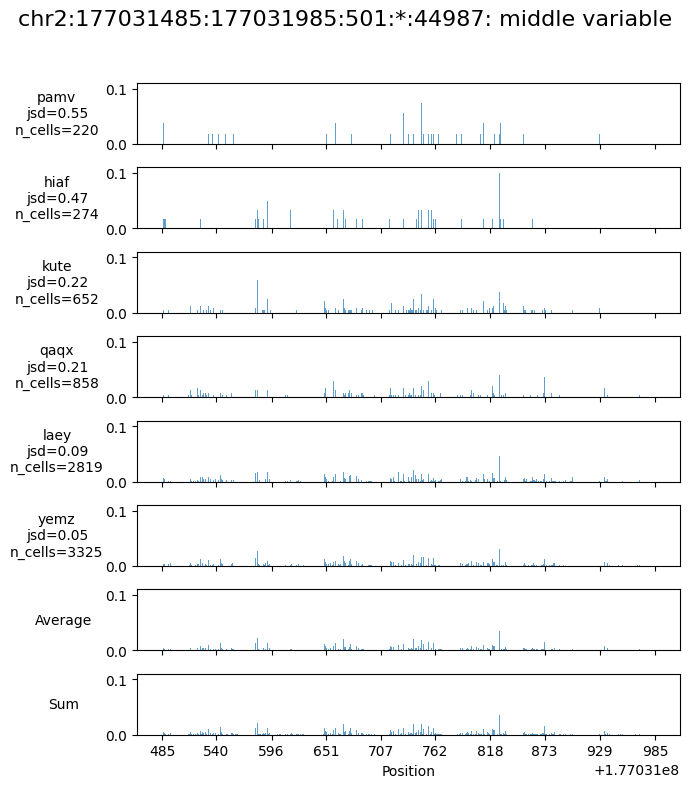

/tmp/ipykernel_2786429/1272777068.py:19: RuntimeWarning: invalid value encountered in divide
  arrays = [peak_profiles[peak][donor] / np.sum(peak_profiles[peak][donor]) for donor in tml_std_jsd_peaks[peak].keys()]


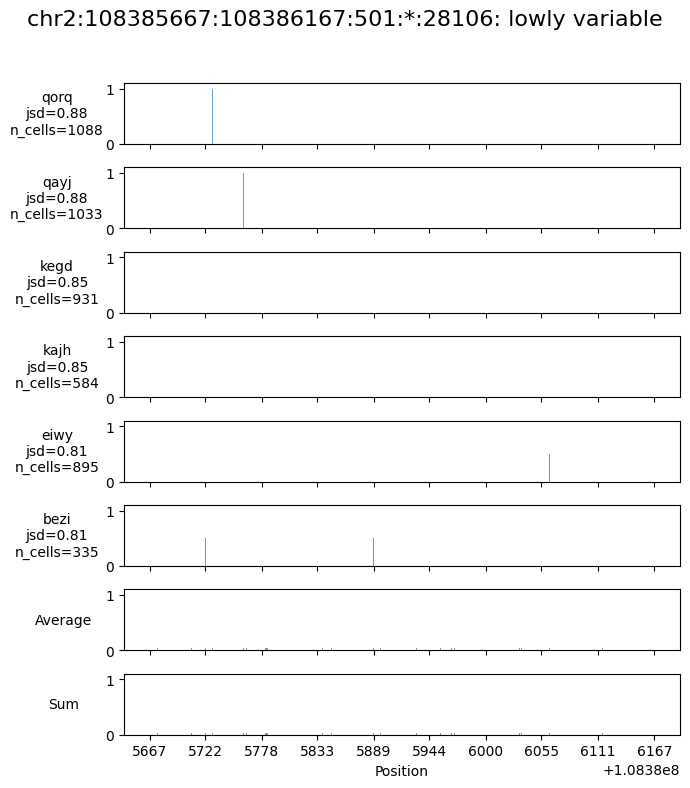

/tmp/ipykernel_2786429/1272777068.py:19: RuntimeWarning: invalid value encountered in divide
  arrays = [peak_profiles[peak][donor] / np.sum(peak_profiles[peak][donor]) for donor in tml_std_jsd_peaks[peak].keys()]


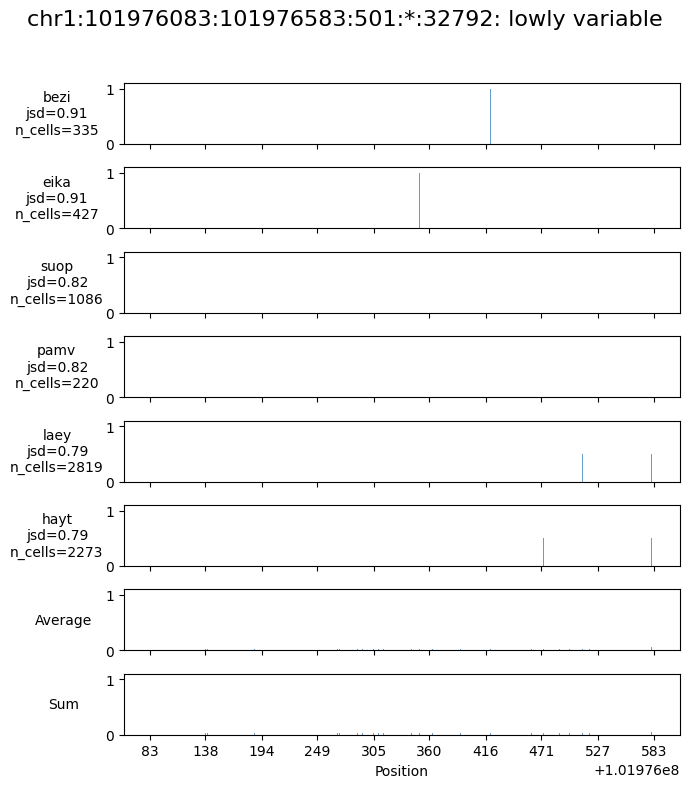

In [ ]:
# Normalized Barplot

for count, peak in enumerate(peaks):

    # Top, middle or low variance/std?
    if count < n_top_hvps:
        
        peak_type = 'highly'

    elif n_top_hvps <= count < n_top_hvps+n_mid_vps:

        peak_type = 'middle'

    elif count >= n_top_hvps+n_mid_vps:

        peak_type = 'lowly'

    # Make objects
    arrays = [peak_profiles[peak][donor] / np.sum(peak_profiles[peak][donor]) for donor in tml_std_jsd_peaks[peak].keys()]
    arrays.append(peak_profiles_average[peak]/ np.sum(peak_profiles_average[peak]))
    arrays.append(peak_profiles_sum[peak] / np.sum(peak_profiles_sum[peak]))

    array_labels = [donor for donor in tml_std_jsd_peaks[peak].keys()]
    array_labels.append('Average')
    array_labels.append('Sum')

    chr, start, end = adata.var.loc[peak, ['chr', 'start', 'end']].to_list()
    positions = np.arange(int(start), int(end) + 1)

    # Check
    assert len(set([len(a) for a in arrays])) == 1
    assert len(positions) == len(arrays[0])

    common_ylim = max(max(a) for a in arrays[0:-1]) * 1.1

    fig, axes = plt.subplots(len(arrays), 1, figsize=(7, 8), sharex=True)

    for i, (array, ax) in enumerate(zip(arrays, axes)):

        donor = array_labels[i]
        
        ax.bar(positions, array, alpha=0.7)

        if array_labels[i] == 'Average':

            ax.set_ylabel(array_labels[i], rotation=0, labelpad=30, va='center')

            ax.set_ylim(0, common_ylim)


        elif array_labels[i] == 'Sum':

            ax.set_ylabel(array_labels[i], rotation=0, labelpad=30, va='center')

            ax.set_ylim(0, common_ylim)

        else:

            ax.set_ylabel('{}\njsd={:.2f}\nn_cells={}'.format(
                array_labels[i],
                tml_std_jsd_peaks[peak][donor],
                int(adata.obs.loc[donor, 'n_cells'])
                ), rotation=0, labelpad=35, va='center')

            ax.set_ylim(0, common_ylim)

        # ax.grid(axis='y', linestyle='--', alpha=0.7)

    ax.set_xticks(np.linspace(positions[0], positions[-1], num=10, dtype=int))  # Use 10 evenly spaced ticks

    plt.xlabel('Position')
    fig.suptitle(f'{peak}: {peak_type} variable', fontsize=16) # ATAC-seq footprint, top/mid/low JSD donors\n\n
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit the title
    plt.show()

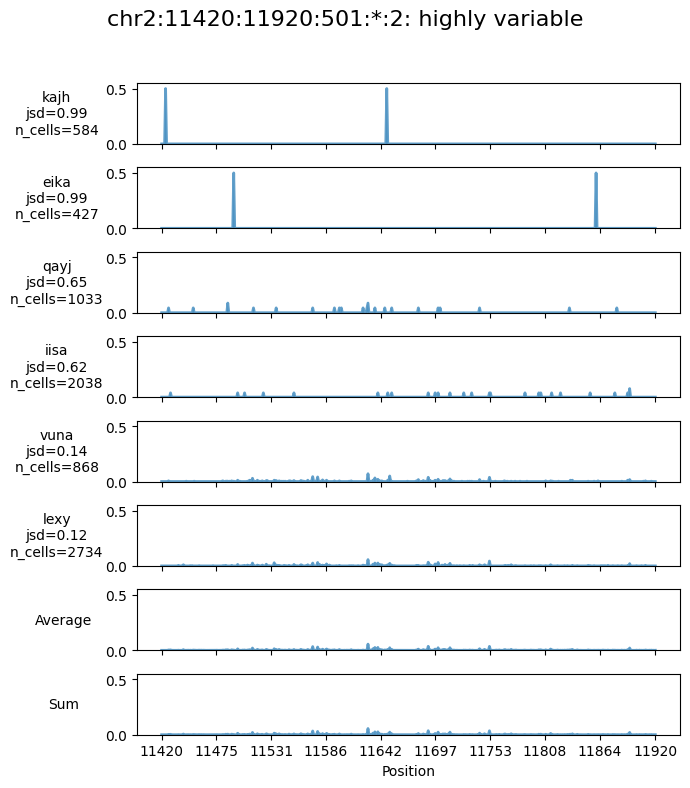

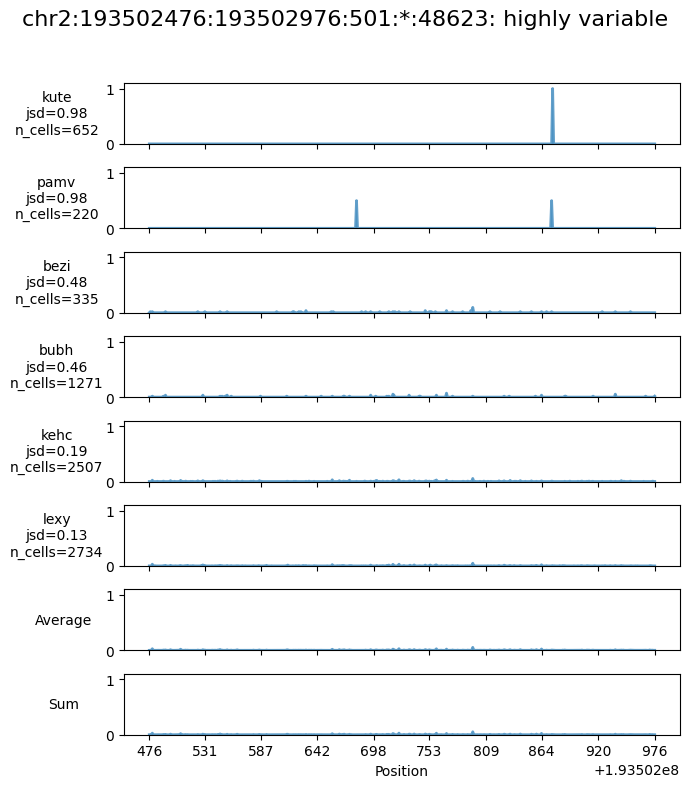

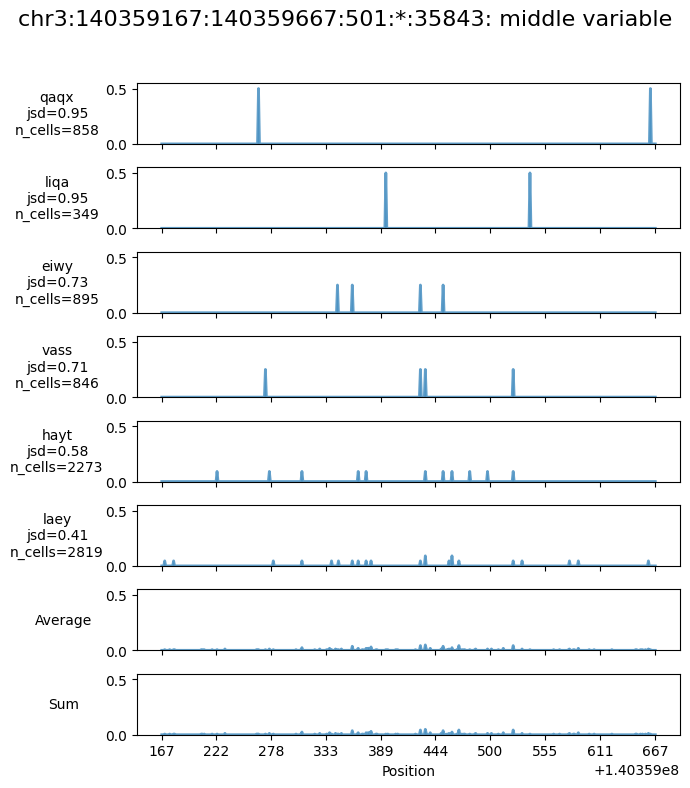

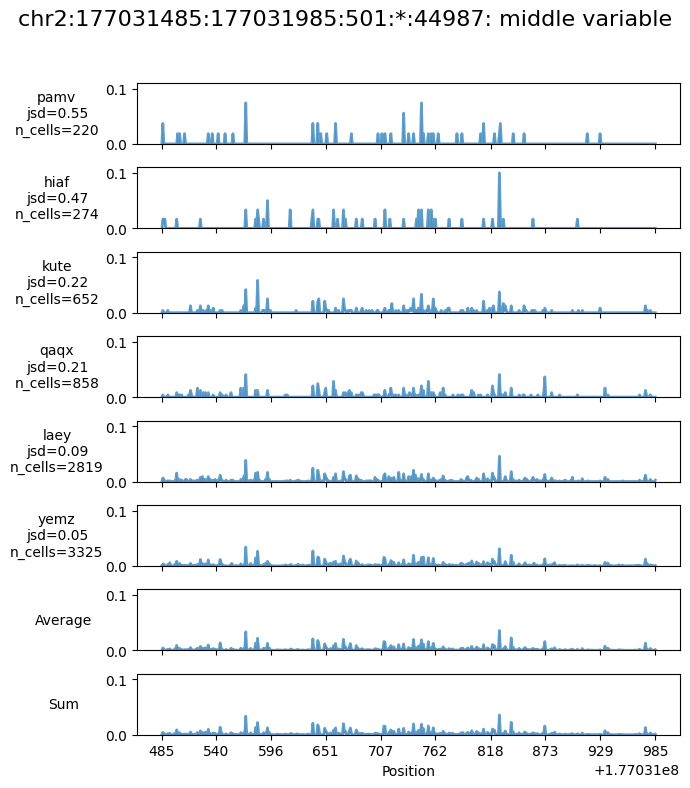

/tmp/ipykernel_2786429/4113003217.py:19: RuntimeWarning: invalid value encountered in divide
  arrays = [peak_profiles[peak][donor] / np.sum(peak_profiles[peak][donor]) for donor in tml_std_jsd_peaks[peak].keys()]


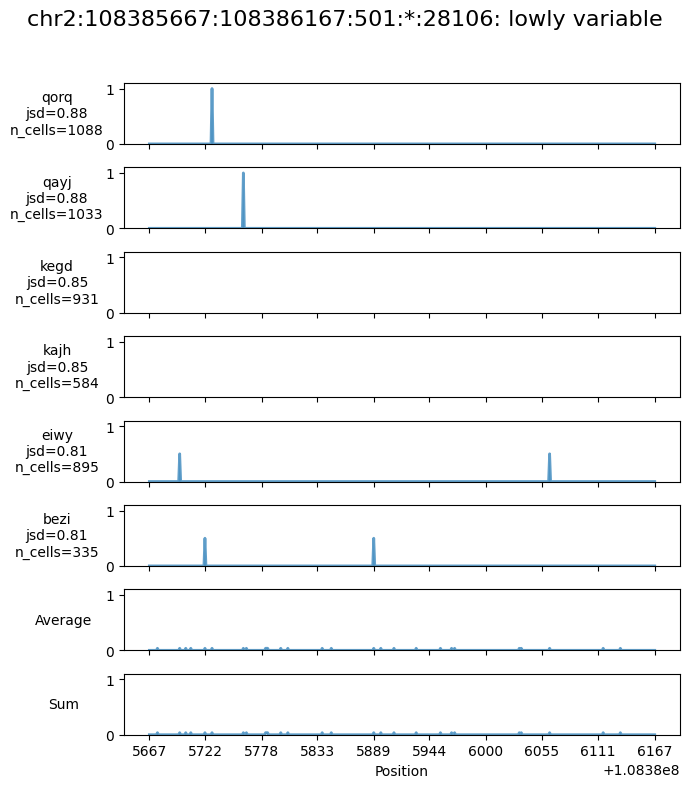

/tmp/ipykernel_2786429/4113003217.py:19: RuntimeWarning: invalid value encountered in divide
  arrays = [peak_profiles[peak][donor] / np.sum(peak_profiles[peak][donor]) for donor in tml_std_jsd_peaks[peak].keys()]


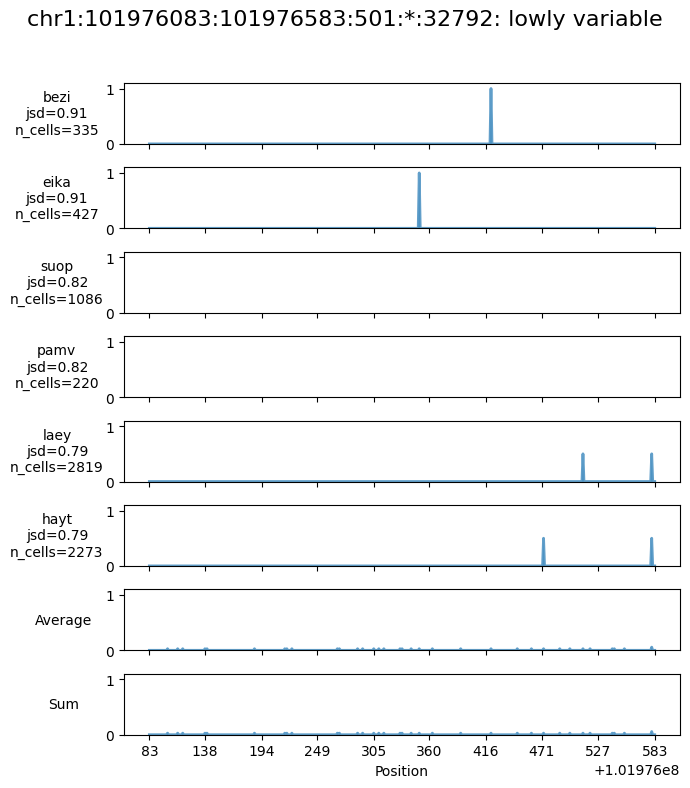

In [ ]:
# Density Barplot

for count, peak in enumerate(peaks):

    # Top, middle or low variance/std?
    if count < n_top_hvps:
        
        peak_type = 'highly'

    elif n_top_hvps <= count < n_top_hvps+n_mid_vps:

        peak_type = 'middle'

    elif count >= n_top_hvps+n_mid_vps:

        peak_type = 'lowly'

    # Make objects
    arrays = [peak_profiles[peak][donor] / np.sum(peak_profiles[peak][donor]) for donor in tml_std_jsd_peaks[peak].keys()]
    arrays.append(peak_profiles_average[peak]/ np.sum(peak_profiles_average[peak]))
    arrays.append(peak_profiles_sum[peak] / np.sum(peak_profiles_sum[peak]))

    array_labels = [donor for donor in tml_std_jsd_peaks[peak].keys()]
    array_labels.append('Average')
    array_labels.append('Sum')

    chr, start, end = adata.var.loc[peak, ['chr', 'start', 'end']].to_list()
    positions = np.arange(int(start), int(end) + 1)

    # Check
    assert len(set([len(a) for a in arrays])) == 1
    assert len(positions) == len(arrays[0])

    common_ylim = max(max(a) for a in arrays[0:-1]) * 1.1

    fig, axes = plt.subplots(len(arrays), 1, figsize=(7, 8), sharex=True)

    for i, (array, ax) in enumerate(zip(arrays, axes)):

        donor = array_labels[i]
        
        ax.plot(positions, array, alpha=0.7, label=array_labels[i], lw=2)
        ax.fill_between(positions, 0, array, alpha=0.3)

        if array_labels[i] == 'Average':

            ax.set_ylabel(array_labels[i], rotation=0, labelpad=30, va='center')

            ax.set_ylim(0, common_ylim)


        elif array_labels[i] == 'Sum':

            ax.set_ylabel(array_labels[i], rotation=0, labelpad=30, va='center')

            ax.set_ylim(0, common_ylim)

        else:

            ax.set_ylabel('{}\njsd={:.2f}\nn_cells={}'.format(
                array_labels[i],
                tml_std_jsd_peaks[peak][donor],
                int(adata.obs.loc[donor, 'n_cells'])
                ), rotation=0, labelpad=35, va='center')

            ax.set_ylim(0, common_ylim)

        # ax.grid(axis='y', linestyle='--', alpha=0.7)

    ax.set_xticks(np.linspace(positions[0], positions[-1], num=10, dtype=int))  # Use 10 evenly spaced ticks

    plt.xlabel('Position')
    fig.suptitle(f'{peak}: {peak_type} variable', fontsize=16) # ATAC-seq footprint, top/mid/low JSD donors\n\n
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit the title
    plt.show()

### Plot: All HVP profiles and save to files

In [13]:
%matplotlib agg

In [18]:
# Top, mid, low variable peaks

n_top_hvps = 2
n_mid_vps = 2
n_low_vps = 2

c_d, c_u = middle_indexes(length=len(adata.var), radial_range=n_mid_vps)

top_hvps = adata.var['std_rank'].sort_values()[0:n_top_hvps].index.to_list()
mid_vps = adata.var['std_rank'].sort_values()[c_d:c_u].index.to_list()
low_vps = adata.var['std_rank'].sort_values()[-n_low_vps:].index.to_list()

peaks = top_hvps + mid_vps + low_vps

peaks

['chr2:11420:11920:501:*:2',
 'chr2:193502476:193502976:501:*:48623',
 'chr2:68649627:68650127:501:*:19729',
 'chr22:24582418:24582918:501:*:2442',
 'chr2:108385667:108386167:501:*:28106',
 'chr1:101976083:101976583:501:*:32792']

In [19]:
peaks_donors_jsd = {peak: {} for peak in peaks} # peak: {donor: jsd} for n_top,mid,low_jsd_donors
peaks_donors_order = {} # peak: [donors]

for peak in peaks:

    jsd_series_sorted = adata[:, peak].to_df()[peak].sort_values(ascending=False)

    # Get donor->jsd
    donors_jsd = jsd_series_sorted.to_dict()
    peaks_donors_jsd[peak] = donors_jsd

    # Get donor order
    peaks_donors_order[peak] = jsd_series_sorted.index.to_list()

peaks_donors_jsd[list(peaks_donors_jsd.keys())[0]]

{'kajh': 0.9875664395160835,
 'eika': 0.9855892668474151,
 'oupf': 0.9650462634655205,
 'qorq': 0.9331024369222406,
 'ualf': 0.9318393010730668,
 'joxm': 0.8932105565363561,
 'fawm': 0.8928049576729622,
 'sebz': 0.8741784684096917,
 'heja': 0.8641637300289028,
 'qaqx': 0.8533276581125074,
 'kehc': 0.8380681855854248,
 'laey': 0.8283272453357657,
 'meue': 0.7809674910750033,
 'hayt': 0.7767204534296708,
 'kute': 0.7716220558510798,
 'sebn': 0.7588174998074307,
 'kegd': 0.7541604413776136,
 'qayj': 0.6533539799203952,
 'iisa': 0.6179725927450905,
 'bubh': 0.5861172758141265,
 'bezi': 0.5523915640693666,
 'suop': 0.5313651802188415,
 'kuxp': 0.5150491597436404,
 'fikt': 0.5042099720727276,
 'eiwy': 0.4508185089407843,
 'uilk': 0.4508185089407843,
 'vass': 0.3889638213893658,
 'liqa': 0.3860195073586873,
 'hiaf': 0.3618195899928878,
 'oapg': 0.31521635813391113,
 'lepk': 0.3054388175609971,
 'yemz': 0.2321136963542895,
 'diku': 0.20600235548220658,
 'vuna': 0.14036951209079632,
 'lexy': 0.

In [20]:
# Peak profiles

peaks_donors_profile = {peak: {} for peak in peaks} # peak: {donor: [profile.np]}

bw_files = list_files_and_links(os.path.join(GROUPED_BIGWIG_FILES_DIR, cell_type))

for bw_file in bw_files:

    donor = bw_file.rstrip('.bw').split('_')[0]
    bw_path_full = os.path.join(GROUPED_BIGWIG_FILES_DIR, cell_type, bw_file)

    if donor not in peaks_donors_order[peak]:

        continue

    # Avoid empty bigwigs
    if not os.stat(bw_path_full).st_size == 0:


        bw = pyBigWig.open(bw_path_full)


        for peak in peaks:
    
            chr, start, end = adata.var.loc[peak, ['chr', 'start', 'end']]

            profile = bw.values(chr, int(start) - 1, int(end))
            profile = np.nan_to_num(profile, nan=0)

            peaks_donors_profile[peak][donor] = profile


        bw.close()

In [21]:
# Peak profiles average across donors

peaks_prof_av = {} # peak: average

for peak in peaks:

    profiles_matrix = np.stack(list(peaks_donors_profile[peak].values()))
    peaks_prof_av[peak] = np.average(profiles_matrix, axis=0)


# Peak profiles sum across donors

peaks_prof_sum = {} # peak: sum

for peak in peaks:

    profiles_matrix = np.stack(list(peaks_donors_profile[peak].values()))
    peaks_prof_sum[peak] = np.sum(profiles_matrix, axis=0)

In [1]:
import numpy as np

In [4]:
np.arange(0,10).reshape(2,5).flatten()

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [27]:
np.max(np.stack(list(peaks_donors_profile['chr2:11420:11920:501:*:2'].values()))) * 1.1

26.400000000000002

In [ ]:
# Barplot --> PDF


donors_p_page = 10

for peak in peaks:

    count = 0

    # Highly, middle or lowly variable?
    if count < n_top_hvps:
        
        peak_type = 'highly'

    elif n_top_hvps <= count < n_top_hvps+n_mid_vps:

        peak_type = 'middle'

    elif count >= n_top_hvps+n_mid_vps:

        peak_type = 'lowly'


    # Get cross-donor max profile insertions value for common_ylim
    profiles = np.stack(list(peaks_donors_profile[peak].values()))
    common_ylim = np.max(profiles.flatten()) * 1.1


    # Prep out file
    pretty_peak_name = "-".join(peak.split(":")[0:4])
    out = os.path.join(FOOTPRINTS_EDA, cell_type, f'footprint_profiles_barplot_{pretty_peak_name}_{cell_type}.pdf')
    create_dir(out)

    # Init pdf
    with PdfPages(out) as pdf:

        # 1 pdf page == 1 iteration
        while count + 1 <= len(peaks_donors_order[peak]):

            # Make paired 1D profile arrays and labels
            profiles = []
            profiles_labels = []

            # Donor profile arrays
            for donor in peaks_donors_order[peak][count:count+donors_p_page]:

                profiles.append(peaks_donors_profile[peak][donor])

            # Average profile array
            profiles.append(peaks_prof_av[peak])

            # Sum profile array
            profiles.append(peaks_prof_sum[peak])


            # Profiles labels
            profiles_labels.extend([donor for donor in peaks_donors_order[peak][count:count+donors_p_page]])
            profiles_labels.append('Average')
            profiles_labels.append('Sum')


            # Useful data
            chr, start, end = adata.var.loc[peak, ['chr', 'start', 'end']].to_list()
            positions = np.arange(int(start), int(end) + 1)

            # Check
            assert len(set([len(a) for a in profiles])) == 1
            assert len(positions) == len(profiles[0])


            # Make fig
            fig, axes = plt.subplots(len(profiles), 1, figsize=(12, 15), sharex=True)

            # Consisting of stacked profile barplots
            for i, (profile, ax) in enumerate(zip(profiles, axes)):

                donor = profiles_labels[i]
                
                ax.bar(positions, profile, alpha=0.7)

                if profiles_labels[i] == 'Average':

                    ax.set_ylabel(profiles_labels[i], rotation=0, labelpad=30, va='center', fontsize=8)

                    ax.set_ylim(0, common_ylim)


                elif profiles_labels[i] == 'Sum':

                    ax.set_ylabel(profiles_labels[i], rotation=0, labelpad=30, va='center', fontsize=8)


                else:

                    ax.set_ylabel('{}\njsd={:.2f}\nn_cells={}'.format(
                        profiles_labels[i],
                        peaks_donors_jsd[peak][donor],
                        int(adata.obs.loc[donor, 'n_cells'])
                        ), rotation=0, labelpad=35, va='center', fontsize=8)

                    ax.set_ylim(0, common_ylim)


                ax.grid(axis='y', linestyle='--', alpha=0.4)

            ax.set_xticks(np.linspace(positions[0], positions[-1], num=10, dtype=int))  # Use 10 evenly spaced ticks

            plt.xlabel('Position')
            fig.suptitle(f'{peak}\n{peak_type} variable - Nearest gene: {adata.var.loc[peak, "nearest_gene"]} - {adata.var.loc[peak, "peak_type"]}', fontsize=16) # ATAC-seq footprint, top/mid/low JSD donors\n\n
            plt.tight_layout(rect=[0, 0, 1, 0.98])  # Adjust layout to fit the title

            # Add page to pdf
            pdf.savefig(fig)#, dpi=300, bbox_inches='tight')
            plt.close(fig)

            count += donors_p_page



chr2:11420:11920:501:*:2
26.400000000000002
chr2:193502476:193502976:501:*:48623
20.900000000000002
chr2:68649627:68650127:501:*:19729
2.2
chr22:24582418:24582918:501:*:2442
2.2
chr2:108385667:108386167:501:*:28106
1.1
chr1:101976083:101976583:501:*:32792
1.1


In [37]:
# Barplot normalized --> PDF


donors_p_page = 10

for peak in peaks:

    count = 0

    # Highly, middle or lowly variable?
    if count < n_top_hvps:
        
        peak_type = 'highly'

    elif n_top_hvps <= count < n_top_hvps+n_mid_vps:

        peak_type = 'middle'

    elif count >= n_top_hvps+n_mid_vps:

        peak_type = 'lowly'


    # Get cross-donor max profile insertions value for common_ylim
    profiles = np.stack(list(peaks_donors_profile[peak].values()))
    profiles_counts = np.sum(profiles, axis=1)
    profiles_norm = profiles / np.where(profiles_counts == 0, 1, profiles_counts)[:, np.newaxis]

    common_ylim = np.max(profiles_norm.flatten()) * 1.1


    # Prep out file
    pretty_peak_name = "-".join(peak.split(":")[0:4])
    out = os.path.join(FOOTPRINTS_EDA, cell_type, f'footprint_profiles_barplot-norm_{pretty_peak_name}_{cell_type}.pdf')
    create_dir(out)

    # Init pdf
    with PdfPages(out) as pdf:

        # 1 pdf page == 1 iteration
        while count + 1 <= len(peaks_donors_order[peak]):

            # Make paired 1D profile arrays and labels
            profiles = []
            profiles_labels = []

            # Donor profile arrays
            for donor in peaks_donors_order[peak][count:count+donors_p_page]:

                profile = peaks_donors_profile[peak][donor]
                profile_norm = profile / np.where(np.sum(profile) == 0, 1, np.sum(profile))
                profiles.append(profile_norm)

            # Average profile array
            profiles_average = peaks_prof_av[peak]
            profiles_average_norm = profiles_average / np.where(np.sum(profiles_average) == 0, 1, np.sum(profiles_average))
            profiles.append(profiles_average_norm)

            # Sum profile array
            profiles_sum = peaks_prof_sum[peak]
            profiles_sum_norm = profiles_sum / np.where(np.sum(profiles_sum) == 0, 1, np.sum(profiles_sum))
            profiles.append(profiles_sum_norm)


            # Profiles labels
            profiles_labels.extend([donor for donor in peaks_donors_order[peak][count:count+donors_p_page]])
            profiles_labels.append('Average')
            profiles_labels.append('Sum')


            # Useful data
            chr, start, end = adata.var.loc[peak, ['chr', 'start', 'end']].to_list()
            positions = np.arange(int(start), int(end) + 1)

            # Check
            assert len(set([len(a) for a in profiles])) == 1
            assert len(positions) == len(profiles[0])


            # Make fig
            fig, axes = plt.subplots(len(profiles), 1, figsize=(12, 15), sharex=True)

            # Consisting of stacked profile barplots
            for i, (profile, ax) in enumerate(zip(profiles, axes)):

                donor = profiles_labels[i]
                
                ax.bar(positions, profile, alpha=0.7)

                if profiles_labels[i] == 'Average':

                    ax.set_ylabel(profiles_labels[i], rotation=0, labelpad=30, va='center', fontsize=8)

                    ax.set_ylim(0, common_ylim)


                elif profiles_labels[i] == 'Sum':

                    ax.set_ylabel(profiles_labels[i], rotation=0, labelpad=30, va='center', fontsize=8)


                else:

                    ax.set_ylabel('{}\njsd={:.2f}\nn_cells={}'.format(
                        profiles_labels[i],
                        peaks_donors_jsd[peak][donor],
                        int(adata.obs.loc[donor, 'n_cells'])
                        ), rotation=0, labelpad=35, va='center', fontsize=8)

                    ax.set_ylim(0, common_ylim)

                ax.grid(axis='y', linestyle='--', alpha=0.4)
                

            ax.set_xticks(np.linspace(positions[0], positions[-1], num=10, dtype=int))  # Use 10 evenly spaced ticks

            plt.xlabel('Position')
            fig.suptitle(f'{peak}\n{peak_type} variable - Nearest gene: {adata.var.loc[peak, "nearest_gene"]} - {adata.var.loc[peak, "peak_type"]}', fontsize=16) # ATAC-seq footprint, top/mid/low JSD donors\n\n
            plt.tight_layout(rect=[0, 0, 1, 0.98])  # Adjust layout to fit the title

            # Add page to pdf
            pdf.savefig(fig)#, dpi=300, bbox_inches='tight')
            plt.close(fig)

            count += donors_p_page



In [38]:
# Density Barplot --> PDF


donors_p_page = 10

for peak in peaks:

    count = 0

    # Highly, middle or lowly variable?
    if count < n_top_hvps:
        
        peak_type = 'highly'

    elif n_top_hvps <= count < n_top_hvps+n_mid_vps:

        peak_type = 'middle'

    elif count >= n_top_hvps+n_mid_vps:

        peak_type = 'lowly'


    # Get cross-donor max profile insertions value for common_ylim
    profiles = np.stack(list(peaks_donors_profile[peak].values()))
    profiles_counts = np.sum(profiles, axis=1)
    profiles_norm = profiles / np.where(profiles_counts == 0, 1, profiles_counts)[:, np.newaxis]

    common_ylim = np.max(profiles_norm.flatten()) * 1.1


    # Prep out file
    pretty_peak_name = "-".join(peak.split(":")[0:4])
    out = os.path.join(FOOTPRINTS_EDA, cell_type, f'footprint_profiles_density-plot_{pretty_peak_name}_{cell_type}.pdf')
    create_dir(out)

    # Init pdf
    with PdfPages(out) as pdf:

        # 1 pdf page == 1 iteration
        while count + 1 <= len(peaks_donors_order[peak]):

            # Make paired 1D profile arrays and labels
            profiles = []
            profiles_labels = []

            # Donor profile arrays
            for donor in peaks_donors_order[peak][count:count+donors_p_page]:

                profile = peaks_donors_profile[peak][donor]
                profile_norm = profile / np.where(np.sum(profile) == 0, 1, np.sum(profile))
                profiles.append(profile_norm)

            # Average profile array
            profiles_average = peaks_prof_av[peak]
            profiles_average_norm = profiles_average / np.where(np.sum(profiles_average) == 0, 1, np.sum(profiles_average))
            profiles.append(profiles_average_norm)

            # Sum profile array
            profiles_sum = peaks_prof_sum[peak]
            profiles_sum_norm = profiles_sum / np.where(np.sum(profiles_sum) == 0, 1, np.sum(profiles_sum))
            profiles.append(profiles_sum_norm)


            # Profiles labels
            profiles_labels.extend([donor for donor in peaks_donors_order[peak][count:count+donors_p_page]])
            profiles_labels.append('Average')
            profiles_labels.append('Sum')


            # Useful data
            chr, start, end = adata.var.loc[peak, ['chr', 'start', 'end']].to_list()
            positions = np.arange(int(start), int(end) + 1)

            # Check
            assert len(set([len(a) for a in profiles])) == 1
            assert len(positions) == len(profiles[0])


            # Make fig
            fig, axes = plt.subplots(len(profiles), 1, figsize=(12, 15), sharex=True)

            # Consisting of stacked profile barplots
            for i, (profile, ax) in enumerate(zip(profiles, axes)):

                donor = profiles_labels[i]
                
                ax.plot(positions, profile, alpha=0.7, label=profiles_labels[i], lw=2)
                ax.fill_between(positions, 0, profile, alpha=0.3)

                if profiles_labels[i] == 'Average':

                    ax.set_ylabel(profiles_labels[i], rotation=0, labelpad=30, va='center', fontsize=8)

                    ax.set_ylim(0, common_ylim)


                elif profiles_labels[i] == 'Sum':

                    ax.set_ylabel(profiles_labels[i], rotation=0, labelpad=30, va='center', fontsize=8)


                else:

                    ax.set_ylabel('{}\njsd={:.2f}\nn_cells={}'.format(
                        profiles_labels[i],
                        peaks_donors_jsd[peak][donor],
                        int(adata.obs.loc[donor, 'n_cells'])
                        ), rotation=0, labelpad=35, va='center', fontsize=8)

                    ax.set_ylim(0, common_ylim)

                ax.grid(axis='y', linestyle='--', alpha=0.4)
                

            ax.set_xticks(np.linspace(positions[0], positions[-1], num=10, dtype=int))  # Use 10 evenly spaced ticks

            plt.xlabel('Position')
            fig.suptitle(f'{peak}\n{peak_type} variable - Nearest gene: {adata.var.loc[peak, "nearest_gene"]} - {adata.var.loc[peak, "peak_type"]}', fontsize=16) # ATAC-seq footprint, top/mid/low JSD donors\n\n
            plt.tight_layout(rect=[0, 0, 1, 0.98])  # Adjust layout to fit the title

            # Add page to pdf
            pdf.savefig(fig)#, dpi=300, bbox_inches='tight')
            plt.close(fig)

            count += donors_p_page

